In [ ]:
import os
import time
import json
import pickle
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import copy
from pprint import pprint
import tensorflow as tf
import keras

In [65]:
tf.__version__

'2.0.0'

In [66]:
# reproducible results 
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.random.set_seed(1234)

#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#set_session(sess)

In [67]:
# prevent tensorflow from allocating the entire GPU memory at once
from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "0"
# set_session(tf.Session(config=config))

# Load data

In [68]:
"""
input data format (csv):

"attribute_1_name", "attribute_2_name", ..., "attribute_n_name"
agent_1_attribute_1_val, agent_1_attribute_1_val, ..., agent_1_attribute_1_val
...
agent_N_attribute_1_val, agent_N_attribute_2_val, ..., agent_N_attribute_n_val

""" 

data_dir = '.'
data_filename = "data.csv"
data_file = os.path.join(data_dir, data_filename)
delimiter = ','
df_all = pd.read_csv(data_file, delimiter=delimiter)
df_all.columns = [c.replace('_', '') for c in df_all.columns]
print(df_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020004 entries, 0 to 1020003
Data columns (total 12 columns):
x             1020004 non-null float64
y             1020004 non-null float64
centreid      1020004 non-null int64
distcentre    1020004 non-null float64
density       1020004 non-null int64
gender        1020004 non-null int64
ethnicity     1020004 non-null int64
hhpeople      1020004 non-null int64
age           1020004 non-null int64
distpt        1020004 non-null float64
income        1020004 non-null int64
hascar        1020004 non-null int64
dtypes: float64(4), int64(8)
memory usage: 93.4 MB
None


In [69]:
# data statistics
df_all.describe().append(df_all.isnull().sum().rename('isnull'))

,x,y,centreid,distcentre,density,gender,ethnicity,hhpeople,age,distpt,income,hascar
count,1.020004e+06,1.020004e+06,1.020004e+06,1.020004e+06,1.020004e+06,1.020004e+06,1.020004e+06,1.020004e+06,1.020004e+06,1.020004e+06,1.020004e+06,1.020004e+06
mean,4.878402e+02,5.183318e+02,5.052465e+01,1.879241e+01,1.509936e+01,5.103656e-01,2.430959e+00,2.408035e+00,3.645734e+01,2.001595e+00,4.982052e+04,1.510818e-01
std,2.564923e+02,2.906490e+02,2.942734e+01,9.832022e+00,9.008658e+00,4.998928e-01,7.664313e-01,1.283970e+00,2.396312e+01,2.450428e+00,1.380828e+04,3.581287e-01
min,-5.647516e+01,-3.484334e+01,0.000000e+00,1.986474e-02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.026223e-14,1.500000e+04,0.000000e+00
25%,2.853194e+02,2.561770e+02,2.500000e+01,1.136724e+01,8.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,1.500000e+01,2.674966e-01,4.000000e+04,0.000000e+00
50%,4.938090e+02,5.606744e+02,5.100000e+01,1.765580e+01,1.400000e+01,1.000000e+00,2.000000e+00,2.000000e+00,3.200000e+01,1.105243e+00,5.000000e+04,0.000000e+00
75%,6.997529e+02,7.507163e+02,7.600000e+01,2.496815e+01,2.100000e+01,1.000000e+00,3.000000e+00,3.000000e+00,6.000000e+01,2.843508e+00,6.000000e+04,0.000000e+00
max,1.037505e+03,1.046971e+03,1.010000e+02,7.867950e+01,6.100000e+01,1.000000e+00,5.000000e+00,5.000000e+00,1.100000e+02,3.527279e+01,1.350000e+05,1.000000e+00
isnull,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


# Prepare data

In [70]:
# names of categorical attributes
categorical = [
    "centreid",
    "gender",
    "ethnicity",
    "hhpeople",
    #...
    "hascar"
]

# names of numerical attributes
numerical = [
    "x",
    "y",
    "distcentre",
    "density",
    "age",
    "distpt",
    #...
    "income"
]

# names of real-valued numerical attributes (a subset of numerical)
numerical_float = [
    "x",
    "y",
    "distcentre",
    "density",
    "distpt",
    #...
]

# names of integer-valued numerical attributes (a subset of numerical)
numerical_int = [
    "age",
    "income"
    #...
]

columns_all = categorical + numerical

# attributes to model
columns_to_use = columns_all

# removing duplicates just in case
columns_to_use = list(set(columns_to_use))

In [77]:
# bins used for the comparison of the joint distribution / discretization of the numerical variables
min_max_bins = { 
    'scheme_1': {
        # name: [minimum_value, maximum_value, number of bins]
        'mumerical_float_attribute_name_i': [0, 99, 100], # 100 bins: [0,1), [1,2), ..., [99,>99)     
        "x": [-100, 1100, 13],
        "y": [-100, 1100, 13],
        "distcentre": [0, 10, 11],
        "density": [0, 10, 11],
        "distpt": [0, 10, 11],
        "age": [0,90,10],
        "income": [0, 150000, 16]
    },
    # ...
}

In [78]:
# caching routine
def get_file_suffix(train_test_ratio, columns_to_use, data_dir, data_filename_name):
    index_file = data_filename_name + '_index' + '.txt'
    index_file = os.path.join(data_dir, index_file)
    is_index_file = os.path.isfile(index_file) 
    if not is_index_file:
        if not os.path.exists(data_dir): 
            os.makedirs(data_dir)
        with open(index_file, 'w') as f:
            f.write('')
    with open(index_file) as f:    
        index = f.readlines()
        index = [x.strip() for x in index]
    key = str(train_test_ratio) + '---'
    key += '---'.join(sorted(columns_to_use))
    if key in index:
        file_suffix = str(index.index(key))
    else:
        file_suffix = str(len(index))
        index.append(key)
        with open(index_file, 'w') as f:
            f.write('\n'.join(index))
    return file_suffix


# get record ids for the train/test split
def get_split_ids(df, split_data_dir, sample, train_test_ratio, file_suffix):
    ids = df.index.tolist()
    num_samples = int(len(ids) * sample)
    num_samples_train = int(num_samples * train_test_ratio)
    train_ids = ids[:num_samples_train]
    test_ids = ids[num_samples_train:num_samples]  
    print(len(train_ids), len(test_ids))
    return train_ids, test_ids


# data cleaning and one-hot encoding of categorical variables
def prepare_data(df, columns_to_use, categorical, numerical):
    numerical = [x for x in numerical if x in columns_to_use]
    categorical = [x for x in categorical if x in columns_to_use]
    df = df[columns_to_use].copy()
    if numerical:
        df[numerical] = df[numerical].apply(pd.to_numeric, errors='coerce')
        df.fillna(df.mean()[numerical], inplace=True)
    if categorical:
        names = list(df[categorical].select_dtypes(include=['float64', 'int64']).columns)
        df[names] = df[names].fillna(-1).astype(int).astype(str)
        # one-hot encoding of categorical variables
        df = pd.get_dummies(data=df, columns=categorical)
    return df

In [79]:
# convert numerical variables to categorical
def add_num_cat_res(df):
    col_cats = []
    for col_name in min_max_bins['scheme_1']:
        if col_name not in df: continue
        b0, b1, bn = min_max_bins['scheme_1'][col_name]
        bin_width = (b1 - b0) / bn
        bins = [b0 + i * bin_width for i in range(bn + 1)]
        col_cat_name = col_name + '--cat-res'
        df[col_cat_name] = df[col_name]
        df[col_cat_name] = df[col_cat_name].apply(lambda x: x if x < b1 else b1 - 10e-10)
        df[col_cat_name] = df[col_cat_name].apply(lambda x: x if x >= b0 else b0)
        df[col_cat_name] = df[col_cat_name].apply(lambda x: b0 + bin_width * int((x - b0) / (b1 - b0) * bn))
        df[col_cat_name] = df[col_cat_name].astype(int)
        categorical += col_cat_name
    df = df.drop(list(min_max_bins['scheme_1'].keys()), axis=1)
    return df

In [80]:
reshuffle = False # reshuffle previous random test/train split
convert_numerical_to_categorical = False
#
data_filename_name, data_filename_ext = data_filename.split('.')
shuffled_data_dir = os.path.join(data_dir, 'shuffled_one_hot')
if not os.path.exists(shuffled_data_dir): 
    os.makedirs(shuffled_data_dir)
shuffled_data_file = os.path.join(shuffled_data_dir, data_filename)   
is_shuffled_data_file = os.path.isfile(shuffled_data_file)
if reshuffle or not is_shuffled_data_file:
    print("preparing df...")
    if convert_numerical_to_categorical:
        df = add_num_cat_res(df)
    df = prepare_data(df_all, columns_all, categorical, numerical)
    df = df.sample(frac=1).reset_index(drop=True) # reshuffle dataframe records
    df.to_pickle(shuffled_data_file)
else:
    df = pd.read_pickle(shuffled_data_file)
    print("df loaded from file")
#
print(shuffled_data_file)
print(df.info())
print(df.columns)

df loaded from file
./shuffled_one_hot/data.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020004 entries, 0 to 1020003
Columns: 123 entries, x to hascar_1
dtypes: float64(4), int64(3), uint8(116)
memory usage: 167.3 MB
None
Index(['x', 'y', 'distcentre', 'density', 'age', 'distpt', 'income',
       'centreid_0', 'centreid_1', 'centreid_10',
       ...
       'ethnicity_3', 'ethnicity_4', 'ethnicity_5', 'hhpeople_1', 'hhpeople_2',
       'hhpeople_3', 'hhpeople_4', 'hhpeople_5', 'hascar_0', 'hascar_1'],
      dtype='object', length=123)


In [81]:
sample = 0.01
train_test_ratio = 0.2 # 20% train / 80% test
#
split_data_dir = 'split'
file_suffix = get_file_suffix(train_test_ratio, columns_to_use, split_data_dir, data_filename_name)
train_ids, test_ids = get_split_ids(df, split_data_dir, sample, train_test_ratio, file_suffix)
# drop unsused variables in the dataframe
numerical = [x for x in numerical if x in columns_to_use]
categorical = [x for x in categorical if x in columns_to_use]
categorical_one_hot = []
for cat in categorical:
    for col in df:
        if cat + '_' in col:
            categorical_one_hot.append(col)
df = df[numerical + categorical_one_hot]

2040 8160


In [82]:
# column indices for numerical and categorical variables
# numerical variables: always the first numerical_col_n columns
# categorical variables: cat_groups [first_index, last_index+1]
numerical_col, categorical_col, cat_groups = [], [], []
col_name_prev = ''
for i, col_name in enumerate(df.columns):
    col_name = col_name.split("_")[0]
    if col_name in numerical:
        numerical_col.append(i)
    elif col_name in categorical:
        categorical_col.append(i)
        if col_name != col_name_prev:
            cat_groups.append(i)
    else:
        raise Exception("unknown column type: " + col_name)
    col_name_prev = col_name
numerical_col_n = len(numerical_col)
categorical_col_n = len(categorical_col)
cat_groups.append(i + 1)
cat_groups_n = len(cat_groups) - 1
#
print(numerical_col_n, numerical_col)
print(categorical_col_n, categorical_col)
print(cat_groups_n, cat_groups)

7 [0, 1, 2, 3, 4, 5, 6]
116 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]
5 [7, 109, 111, 116, 121, 123]


In [83]:
data = df.as_matrix()
data = data.astype(np.float32, copy=False)
features_n = len(data[0])
#
data_train = data[train_ids]
data_test = data[test_ids]
#
print(features_n)
print(data_train.shape)
print(data_test.shape)
#print(data[:2, 0:29])

123
(2040, 123)
(8160, 123)


In [84]:
print('\n--- CATEGORICAL ---')
col_names = df.columns.tolist()
for g_i in range(cat_groups_n):
    g_i_beg = cat_groups[g_i]
    g_i_end = cat_groups[g_i + 1]
    group_i_names = col_names[g_i_beg: g_i_end]
    col_name = '_'.join(col_names[g_i_beg].split('_')[:-1])
    print(80*'-')
    print(col_name, len(group_i_names))


--- CATEGORICAL ---
--------------------------------------------------------------------------------
centreid 102
--------------------------------------------------------------------------------
gender 2
--------------------------------------------------------------------------------
ethnicity 5
--------------------------------------------------------------------------------
hhpeople 5
--------------------------------------------------------------------------------
hascar 2


# Validation and caching helper functions

In [85]:
# caching and temp directories
model_cache_dir = 'model_cache'
temp_dir = 'temp'
if not os.path.exists(temp_dir): 
    os.makedirs(temp_dir)

In [86]:
import matplotlib.ticker as ticker
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

    
# check and plot marginals 
def check_marginals(data, bins=None, title=None):
    fig, ax = plt.subplots(figsize=(3, 3), dpi=200, facecolor='w', edgecolor='k')
    colors = ['cornflowerblue', 'seagreen', 'tomato', 'darkorchid']
    labels = ['true', 'pred', 'bla1', 'bla2']
    data_len = len(data)
    colors = colors[:data_len]
    labels = labels[:data_len]
    weights = [np.ones_like(d)/float(len(d)) for d in data]
    if bins is not None:
        counts, bins, patches = ax.hist(data, histtype='bar', color=colors, 
                                        label=labels, normed=False, bins=bins, weights=weights, rwidth=None)#5
    else:
        counts, bins, patches = ax.hist(data, histtype='bar', color=colors, 
                                        label=labels, normed=False, weights=weights, rwidth=None)#20
    ax.set_yscale('log')
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    if title is not None:
        plt.title(title)
    plt.ylim((1e-5, 1))
    plt.tight_layout()
    fig.savefig(os.path.join(temp_dir, '{}.pdf'.format(title)), dpi=fig.dpi)
    plt.show()
    corr = np.corrcoef(counts[0], counts[1])[0, 1]
    rmse = ((counts[0] - counts[1]) ** 2).mean() ** .5
    print("corr =", corr)
    print("rmse =", rmse)
    
    
# compare two vectors: Y_test (true) and Y_pred (predicted)
def compute_stat(Y_test, Y_pred, do_plot, plot_log):
    Y_test, Y_pred = np.array(Y_test), np.array(Y_pred)
    corr_mat = np.corrcoef(Y_test, Y_pred)
    corr = corr_mat[0, 1]
    if np.isnan(corr): corr = 0.0
    # MAE
    mae = np.absolute(Y_test - Y_pred).mean()
    # RMSE
    rmse = np.linalg.norm(Y_test - Y_pred) / np.sqrt(len(Y_test))
    # SRMSE
    ybar = Y_test.mean()
    srmse = rmse / ybar
    # r-square
    u = np.sum((Y_pred - Y_test)**2)
    v = np.sum((Y_test - ybar)**2)
    r2 = 1.0 - u / v
    stat = {'mae': mae, 'rmse': rmse, 'r2': r2, 'srmse': srmse, 'corr': corr}
    if do_plot:
        fig = plt.figure(figsize=(3, 3), dpi=200, facecolor='w', edgecolor='k')
        #plot
        print('corr = %f' % (corr))
        print('MAE = %f' % (mae))
        print('RMSE = %f' % (rmse))
        print('SRMSE = %f' % (srmse))
        print('r2 = %f' % (r2))
        min_Y = min([min(Y_test),min(Y_pred)])
        max_Y = max([max(Y_test),max(Y_pred)])
        w = max_Y - min_Y
        max_Y += w * 0.05
        text = ['SMRSE = {:.3f}'.format(stat['srmse']),
                'Corr = {:.3f}'.format(stat['corr']),
                '$R^2$ = {:.3f}'.format(stat['r2'])]
        text = '\n'.join(text)
        plt.text(w * 0.08, w * 0.8, text)
        plt.plot(Y_test, Y_pred, '.', alpha=0.5, ms=10, color='seagreen', markeredgewidth=0)
        plt.plot([min_Y, max_Y], [min_Y, max_Y], ls='--', color='gray', linewidth=1.0)
        plt.axis([min_Y, max_Y, min_Y, max_Y])
        plt.xlabel('true')
        plt.ylabel('predicted')
        if plot_log:
            eps = 1e-6
            plt.axis([max(min_Y, eps), max_Y, max(min_Y, eps), max_Y])
            plt.yscale('log')
            plt.xscale('log')
        #fig.savefig(os.path.join(temp_dir, '{}.pdf'.format(ylabel)), dpi=fig.dpi)
        plt.show()
    return stat

In [87]:
# The functions below are for the comparison of joint distributions 
# and calculation of conditionals for the Gibbs sampler
# ! Global variables, like "min_max_bins", are used !

# get bin id for a numerical value
def get_bin_i(min_val, max_val, val, bins_n):
    #print(val, max_val, min_val)
    if val >= max_val: val = max_val - 1e-10
    if val < min_val: val = min_val
    return int((val - min_val) / (max_val - min_val) * bins_n)


# calculate frequency of bins
def calc_data_freq(data, min_max_num_bin, var_is_ignore, var_g_is_ignore):
    data_freq = {}
    #print(var_is_ignore, var_g_is_ignore)
    for vals in data:
        bin_key = get_bin_key(vals, min_max_num_bin, var_is_ignore, var_g_is_ignore)
        #print(bin_key)
        #raise Exception("test")
        if bin_key not in data_freq:
            data_freq[bin_key] = 0
        data_freq[bin_key] += 1
    for k in data_freq.keys():
        data_freq[k] /= len(data)
    return data_freq


# frequency of bins + caching
def get_data_freq(data, min_max_num_bin, var_is_ignore, var_g_is_ignore, cache_file=None):
    print(cache_file)
    if cache_file is not None:
        is_cache_file = os.path.isfile(cache_file)
        if is_cache_file:
            with open(cache_file, 'rb') as f:
                data_freq = pickle.load(f)
            print("data_freq loaded from file:", cache_file)
        else:
            print('calc_data_freq started')
            start = time.time()
            data_freq = calc_data_freq(data, min_max_num_bin, var_is_ignore, var_g_is_ignore)
            duration = time.time() - start
            print("Took {} seconds to calc_data_freq".format(duration))
            with open(cache_file, 'wb') as f:
                pickle.dump(data_freq, f)
            print("data_freq saved to file:", cache_file)
    else:
        data_freq = calc_data_freq(data, min_max_num_bin, var_is_ignore, var_g_is_ignore)
    return data_freq


# calculate min_max_bins for an arbitrary discretization scheme
def get_min_max_num_bin(data_test, data_pred, num_bin):
    if num_bin in min_max_bins:
        min_max_num_bin = min_max_bins[num_bin]
    else:
        col_names_num = df.columns.tolist()[:numerical_col_n]
        # calculate min max for nmerical columns
        min_max = {col_names_num[i]: [0, 0, num_bin] for i in range(numerical_col_n)}
        
        for i in range(numerical_col_n):
            col_test = data_test[:, i]
            col_pred = data_pred[:, i]
            min_max[col_names_num[i]][0] = min(np.min(col_test), np.min(col_pred))
            min_max[col_names_num[i]][1] = max(np.max(col_test), np.max(col_pred))
        #print(min_max)
        eps = 1e-10
        for i in range(numerical_col_n):
            min_max[col_names_num[i]][0] -= eps
            min_max[col_names_num[i]][1] += eps
        #
        min_max_num_bin = min_max
    return min_max_num_bin


# comare distributions
def compare_joints_bins(data_test, data_pred, num_bin, 
                        data_test_freq=None, min_max_num_bin=None,
                        var_is_ignore=None, var_g_is_ignore=None,
                        cache_file_test=None, cache_file_pred=None):
    if min_max_num_bin is None:
        min_max_num_bin = get_min_max_num_bin(data_test, data_pred, num_bin)
    #
    if data_test_freq is None:
        data_test_freq = get_data_freq(data_test, min_max_num_bin, 
                                        var_is_ignore, var_g_is_ignore,
                                        cache_file_test) 
    data_pred_freq = get_data_freq(data_pred, min_max_num_bin,
                                    var_is_ignore, var_g_is_ignore,
                                    cache_file_pred) 
    #print("data_test_freq:", data_test_freq)
    #print("data_pred_freq:", data_pred_freq)
    #
    print(80 * '-')
    print("numerical var bins_n =", num_bin)
    data_test_freq_list, data_pred_freq_list = [], []
    for k in data_test_freq.keys():
        data_test_freq_list.append(data_test_freq[k])
        if k in data_pred_freq:
            data_pred_freq_list.append(data_pred_freq[k])
        else:
            data_pred_freq_list.append(0.0)
    for k in data_pred_freq.keys():
        if k not in data_test_freq:
            data_pred_freq_list.append(data_pred_freq[k])
            data_test_freq_list.append(0.0)
    #
    data_space_size = len(data_test_freq_list)
    stat = compute_stat(data_test_freq_list, data_pred_freq_list, True, False)
    print("data_space_size =", data_space_size)
    print(stat)
    print(80 * '-')
    return stat


# basically the same as get_min_max_num_bin but the min/max values are used for one set of samples
def calc_min_max_num_bin(data, num_bin):
    col_names_num = df.columns.tolist()[:numerical_col_n]
    # calculate min max for nmerical columns
    min_max = {col_names_num[i]: [0, 0, num_bin] for i in range(numerical_col_n)}
    for i in range(numerical_col_n):
        min_max[col_names_num[i]][0] = np.min(vals)
        min_max[col_names_num[i]][1] = np.max(vals)
    #print(min_max)
    eps = 1e-10
    for i in range(numerical_col_n):
        min_max[col_names_num[i]][0] -= eps
        min_max[col_names_num[i]][1] += eps
    return min_max


# key of a bin in the frequecy table (aka joint distribution), like "var_1=val_1,var_2=_val_2,..."
def get_bin_key(vals, min_max_num_bin, var_is_ignore, var_g_is_ignore):
    bin_key = []
    col_names_num = df.columns.tolist()[:numerical_col_n]
    for i, val in enumerate(vals[: numerical_col_n]):
        if var_is_ignore is not None and i in var_is_ignore:
            continue
            
        bin_i = get_bin_i(min_max_num_bin[col_names_num[i]][0], 
                          min_max_num_bin[col_names_num[i]][1], 
                          val, 
                          min_max_num_bin[col_names_num[i]][2])
        bin_key.append('num' + str(i) + ":bin" + str(bin_i))
    for g_i in range(cat_groups_n): 
        if var_g_is_ignore is not None and g_i in var_g_is_ignore: continue
        g_i_beg = cat_groups[g_i]
        g_i_end = cat_groups[g_i + 1]
        val_cat = vals[g_i_beg: g_i_end]
        bin_i = np.argmax(val_cat)
        bin_key.append('cat' + str(g_i) + ":bin" + str(bin_i))
    bin_key = "--".join(bin_key)
    return bin_key


# conditionals of the numerical variables for the Gibbs sampler
def calc_full_conditionals_num(args):
    var_i, full_cond, data, min_max_num_bin = args
    print("var_i={}".format(var_i))
    var_name = 'num' + str(var_i)
    full_cond[var_name] = {}
    for vals in data:
        bin_key = get_bin_key(vals, min_max_num_bin, [var_i], None)
        if bin_key not in full_cond[var_name]:
            full_cond[var_name][bin_key] = []
        full_cond[var_name][bin_key].append(vals[var_i])


# conditionals of the categorical variables for the Gibbs sampler
def calc_full_conditionals_cat(args):
    var_g_i, full_cond, data, min_max_num_bin, cat_groups = args
    print("var_g_i={}".format(var_g_i))
    var_name = 'cat' + str(var_g_i)
    full_cond[var_name] = {}
    for vals in data:
        bin_key = get_bin_key(vals, min_max_num_bin, None, [var_g_i])
        if bin_key not in full_cond[var_name]:
            full_cond[var_name][bin_key] = []
        var_g_i_beg = cat_groups[var_g_i]
        var_g_i_end = cat_groups[var_g_i + 1]
        full_cond[var_name][bin_key].append(vals[var_g_i_beg: var_g_i_end])
        

# conditionals for the Gibbs sampler
def calc_full_conditionals(data, num_bin):
    print("caclulating conditional for num_bin={}".format(num_bin))
    # full_cond = {var_name: {bin_key: [vals_of_var_name]}}
    full_cond = {}
    #
    if num_bin in min_max_bins:
        min_max_num_bin = min_max_bins[num_bin]
    else:
        min_max_num_bin = calc_min_max_num_bin(data, num_bin)
    for var_i in range(numerical_col_n):
        args = (var_i, full_cond, data, min_max_num_bin)
        calc_full_conditionals_num(args)
    for var_g_i in range(cat_groups_n):
        args = (var_g_i, full_cond, data, min_max_num_bin, cat_groups)
        calc_full_conditionals_cat(args)
    data_space_size = 0
    for var_name in full_cond:
        data_space_size += len(full_cond[var_name])
    print("data_space_size =", data_space_size)
    #
    return full_cond

In [88]:
# compare marginal distributions of the samples
# argument data = [samples_vae, samples_test, ...]

def check_marginals_numerical(data, num_bin):
    print('\n--- NUMERICAL ---')
    col_names_num = df.columns.tolist()[:numerical_col_n]
    for col_ind, col_name in enumerate(col_names_num):
        print(80*'-')
        print(col_name)
        d_cols = []
        for d in data:
            d_col = d[:, col_ind]
            if col_name in numerical_int:
                d_col = np.around(d_col)
                print("//int//")
            d_col = np.clip(d_col, 
                            min_max_bins[num_bin][col_name][0], 
                            min_max_bins[num_bin][col_name][1])
            d_cols.append(d_col)
            print(d_col[:10])
        title = col_name.split('--')[0]
        check_marginals(d_cols, bins=min_max_bins[num_bin][col_name][2], title=title)
        print(80*'-')
        
    
def check_marginals_categorical(data):
    print('\n--- CATEGORICAL ---')
    col_names = df.columns.tolist()
    for g_i in range(cat_groups_n):
        g_i_beg = cat_groups[g_i]
        g_i_end = cat_groups[g_i + 1]
        group_i_names = col_names[g_i_beg: g_i_end]
        col_name = '_'.join(col_names[g_i_beg].split('_')[:-1])
        print(80*'-')
        print(col_name, len(group_i_names))
        d_cols = []
        for d in data:
            d_col = d[:, g_i_beg:g_i_end]
            d_col = np.argmax(d_col, axis=1)
            d_cols.append(d_col)
            print(d_col[:10])
        title = col_name.split('--')[0]
        check_marginals(d_cols, title=title)
        print(80*'-')

In [89]:
# finding nearest samples for the diversity test

from sklearn.neighbors import BallTree

def get_k_nearest_samples_dist(data_test, data_pred, k, N, var_is_ignore, var_g_is_ignore):
    cols_to_use = []
    for col_i in range(numerical_col_n + categorical_col_n):
        add_col = True
        if var_is_ignore is not None and col_i in var_is_ignore: 
            add_col = False
        if var_g_is_ignore is not None:
            for g_i in var_g_is_ignore:
                if cat_groups[g_i] <= col_i < cat_groups[g_i + 1]:
                    add_col = False
        if add_col:
            cols_to_use.append(col_i)
    #
    tree = BallTree(data_test[:, cols_to_use], leaf_size=k)
    dist_all = []
    data_ind = np.arange(len(data_pred))
    np.random.shuffle(data_ind)
    data_ind = data_ind[:N]
    for i in data_ind:
        sample_pred = data_pred[i, cols_to_use]
        dist, ind = tree.query([sample_pred], k=k)
        dist[0] /= np.sqrt(len(cols_to_use))
        dist_all += dist[0].tolist()
    return np.array(dist_all), data_ind

In [90]:
# calculate data for the plots of models' performance (used in the plot_res function)
def get_perform_plot_data(stat, bin_n_comparisons, samples_keys, sort=False):
    errors, diversity_1, diversity_2, xticks = {}, {}, {}, {}
    x = range(len(samples_keys))
    for bin_n_c in bin_n_comparisons:
        print(80 * "-")
        print("bin_n_comparison =", bin_n_c)
        errors[bin_n_c] = [stat[bin_n_c][k]['joint_pdf'][error_measure] 
                           for k in samples_keys]
        diversity_1[bin_n_c] = [stat[bin_n_c][k]['nearest_samples_dist'][diversity_measure_1]
                                for k in samples_keys]
        diversity_2[bin_n_c] = [stat[bin_n_c][k]['nearest_samples_dist'][diversity_measure_2]
                                for k in samples_keys]
        #
        if sort:
            errors_sorted = list(enumerate(errors[bin_n_c]))
            errors_sorted = sorted(errors_sorted, key=lambda x: x[1], reverse=True)
            ind = [x[0] for x in errors_sorted]
            errors[bin_n_c] = [errors[bin_n_c][i] for i in ind]
            diversity_1[bin_n_c] = [diversity_1[bin_n_c][i] for i in ind]
            diversity_2[bin_n_c] = [diversity_2[bin_n_c][i] for i in ind]
            xticks[bin_n_c] = [samples_keys[i] for i in ind]
        else:
            xticks[bin_n_c] = samples_keys
        #
        plot_res(x, errors[bin_n_c], xticks=xticks[bin_n_c],
                 **error_plot_params[error_measure])
        plot_res(x, diversity_1[bin_n_c], xticks=xticks[bin_n_c], 
                 **diversity_plot_params[diversity_measure_1])
        plot_res(x, diversity_2[bin_n_c], xticks=xticks[bin_n_c], 
                 **diversity_plot_params[diversity_measure_2])
        print(80 * "-")
    return errors, diversity_1, diversity_2, xticks


# plot performance of the models
def plot_res(x, y, ylim=None, color=None, ylabel=None, xticks=None, 
             h_lines=None, h_labels=None, title=None):
    figsize = (18, 9)
    #linestyles = ['--', '-.', ':', '-']
    linestyles = [
        (0, ()),
        (0, (1, 10)),
        (0, (1, 1)),
        (0, (5, 5)),
        (0, (3, 5, 1, 5)),
        (0, (3, 5, 1, 5, 1, 5)),
    ]
    """
    linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])
    """
    fig, ax = plt.subplots(figsize=figsize)
    if xticks is not None:
        plt.xticks(x, xticks, rotation='vertical')
    ax.set_ylabel(ylabel, color=color)
    ax.plot(x, y, color=color)
    ax.plot(x, y, 'o', color=color)
    #
    text = []
    text.append('model min = {}'.format(min(y)))
    #
    if h_lines is not None:
        for i, line_y in enumerate(h_lines):
            if ylim[0] <= line_y <= ylim[1]:
                ax.axhline(line_y, ls=linestyles[i], color=color)
                if h_labels is not None:
                    ax.text(0.0, line_y + (ylim[1] - ylim[0]) / 250, h_labels[i], color=color)
            text.append('{} = {:.3f}'.format(h_labels[i], line_y))
    #
    text = '\n'.join(text)
    ax.text(0.0, ylim[1], text, color=color)
    print(text)
    #
    ax.tick_params(axis='y', labelcolor=color)
    ax.set_ylim(ylim)
    ax.set_title(title)
    #
    #fig.savefig('{}.pdf'.format(ylabel), dpi=fig.dpi)
    plt.show()

In [105]:
# calculate performance of the models + caching
def get_stat(samples_true, samples_pred, samples_train, bin_n_comparisons, 
             samples_true_cache_dir, samples_pred_cache_dir,
             var_is_ignore=None, var_g_is_ignore=None):
    tree_k = 1
    stat = {}
    N = len(bin_n_comparisons) * len(samples_pred)
    i = 0
    if not os.path.exists(samples_true_cache_dir): 
        os.makedirs(samples_true_cache_dir)
    cache_filename = 'freq_cache_file'
    cache_filename += '--' + 'var_is_ignore=' + str(var_is_ignore)
    cache_filename += '--' + 'var_g_is_ignore=' + str(var_g_is_ignore)
    if len(cache_filename) > 255:
        cache_filename = cache_filename.replace(' ', '')
    #
    for bin_n_c in bin_n_comparisons:
        #
        data_test_freq_cache_file = os.path.join(samples_true_cache_dir, cache_filename 
                                                 + '--' + 'bin_n_c=' + str(bin_n_c) 
                                                 + '--' + file_suffix + '.pickle')
        print(data_test_freq_cache_file)
        #
        min_max_num_bin = get_min_max_num_bin(data_test, data_train, bin_n_c)
        
        
        
        
        
        data_test_freq = get_data_freq(data_test, min_max_num_bin, 
                                       var_is_ignore, var_g_is_ignore,
                                       data_test_freq_cache_file)
        stat[bin_n_c] = {}
        for k in samples_pred:
            print(80 * '+')
            print("bin_n_c =", bin_n_c)
            print("samples:", k)
            i += 1
            print("Calculating {} out of {}".format(i, N))
            #
            if np.isnan(samples_pred[k]).any():
                print("!!! nan in samples_pred !!!")
                samples_pred[k] = np.nan_to_num(samples_pred[k])
            #
            if '.' in k:
                samples_pred_cache_dir_ = os.path.join(samples_pred_cache_dir, 
                                                       ",".join(k.split('.')[:-1]))
            else:
                samples_pred_cache_dir_ = os.path.join(samples_pred_cache_dir, k)
            if not os.path.exists(samples_pred_cache_dir_): 
                os.makedirs(samples_pred_cache_dir_)
            #print(k, samples_pred_cache_dir_)
            data_pred_freq_cache_file = os.path.join(samples_pred_cache_dir_, cache_filename 
                                                     + '--' + 'bin_n_c=' + str(bin_n_c) 
                                                     + '--' + file_suffix + '.pickle')
            #
            stat[bin_n_c][k] = {}
            start = time.time()
            stat[bin_n_c][k]['joint_pdf'] = compare_joints_bins(samples_true, samples_pred[k], bin_n_c
                                                   , data_test_freq, min_max_num_bin,
                                                    var_is_ignore, var_g_is_ignore,
                                                    data_test_freq_cache_file, data_pred_freq_cache_file
                                                  )
            duration = time.time() - start
            print("Took {} seconds to compare_joints_bins".format(duration))
            nearest_samples_dist_filename = 'nearest_samples_dist--'\
                                                     + 'samples_train--'\
                                                     + cache_filename\
                                                     + '--' + file_suffix + '.pickle'
            nearest_samples_ind_filename = 'nearest_samples_ind--'\
                                                     + 'samples_train--'\
                                                     + cache_filename\
                                                     + '--' + file_suffix + '.pickle'
            if len(nearest_samples_dist_filename) > 255:
                nearest_samples_dist_filename = nearest_samples_dist_filename.replace(' ', '')
            if len(nearest_samples_ind_filename) > 255:
                nearest_samples_ind_filename = nearest_samples_ind_filename.replace(' ', '')
            nearest_samples_dist_file = os.path.join(samples_pred_cache_dir_, 
                                                     nearest_samples_dist_filename)
            nearest_samples_ind_file = os.path.join(samples_pred_cache_dir_, 
                                                     nearest_samples_ind_filename)
            is_nearest_samples_dist_file = os.path.isfile(nearest_samples_dist_file)
            is_nearest_samples_ind_file = os.path.isfile(nearest_samples_ind_file)
            if is_nearest_samples_dist_file and is_nearest_samples_ind_file:
                with open(nearest_samples_dist_file, 'rb') as f:
                    nearest_samples_dist = pickle.load(f)
                print("nearest_samples_dist loaded from file:", nearest_samples_dist_file)
                with open(nearest_samples_ind_file, 'rb') as f:
                    nearest_samples_ind = pickle.load(f)
                print("nearest_samples_ind loaded from file:", nearest_samples_ind_file)
            else:
                start = time.time()
                nearest_samples_dist, nearest_samples_ind = get_k_nearest_samples_dist(samples_train, 
                        samples_pred[k], tree_k, len(samples_train), var_is_ignore, var_g_is_ignore)
                duration = time.time() - start
                print("Took {} seconds to get_k_nearest_samples_dist".format(duration))
                with open(nearest_samples_dist_file, 'wb') as f:
                    pickle.dump(nearest_samples_dist, f)
                print("nearest_samples_dist saved to file:", nearest_samples_dist_file)
                with open(nearest_samples_ind_file, 'wb') as f:
                    pickle.dump(nearest_samples_ind, f)
                print("nearest_samples_ind saved to file:", nearest_samples_ind_file)
            
            # calc errors / diversity
            stat[bin_n_c][k]['nearest_samples_dist'] = {}
            stat[bin_n_c][k]['nearest_samples_dist']['mean'] = nearest_samples_dist.mean()
            stat[bin_n_c][k]['nearest_samples_dist']['stddev'] = nearest_samples_dist.std()
            stat[bin_n_c][k]['nearest_samples_dist']['frac0'] = \
                np.count_nonzero(nearest_samples_dist == 0) / len(nearest_samples_dist)
            #
            stat[bin_n_c][k]['nearest_samples_dist']['dist'] = nearest_samples_dist
            stat[bin_n_c][k]['nearest_samples_dist']['ind'] = nearest_samples_ind
            #
            print('nearest_samples_dist =', stat[bin_n_c][k]['nearest_samples_dist'])
            print(80 * '+')
    return stat

In [106]:
# calculate attribute column ids to ignore during comparison of the models
# e.g. ignore all attributes except for the Basic
def get_columns_to_ignore(selected_columns):
    col_names = df.columns.tolist()
    #print(len(col_names), col_names)
    #print(cat_groups_n, cat_groups)
    var_is_ignore, var_g_is_ignore = [], []
    for col_i, col_name in enumerate(col_names):
        ignore_column = True
        for col_name_selected in selected_columns:
            if col_name_selected == col_name.split("_")[0]:
                ignore_column = False
                break
        if ignore_column:
            if col_i in numerical_col:
                var_is_ignore.append(col_i)
            else:
                var_g_i = -1
                for g_i, upper_limit in enumerate(cat_groups):
                    #print(col_i, upper_limit)
                    if col_i < upper_limit:
                        var_g_i = g_i - 1
                        break
                var_g_is_ignore.append(var_g_i)
    var_g_is_ignore = list(set(var_g_is_ignore))
    return var_is_ignore, var_g_is_ignore

# Performance measure parameters

In [107]:
# compare numercal distributions using 1) scheme_1 in min_max_bins, 2) 10 uniform bins
bin_n_comparisons = ['scheme_1', 10]
error_measure = 'srmse'
diversity_measure_1 = 'mean'
diversity_measure_2 = 'stddev'
samples_true_cache_dir = os.path.join(model_cache_dir, 'data_test')
samples_train_cache_dir = os.path.join(model_cache_dir, 'data_train')
#
error_plot_params = {
    'srmse': {
        'ylabel': 'srmse',
        'ylim': (0, 5),
        #'color': 'tab:red',
        'color': 'k',
        'title': 'real vs synthetic samples: joint pdf comparison'
    },
    'r2': {
        'ylabel': 'r2',
        'ylim': (-5, 1.1),
        #'color': 'tab:red',
        'color': 'k',
        'title': 'real vs synthetic samples: joint pdf comparison'
    },
    'corr': {
        'ylabel': 'corr',
        'ylim': (0, 1.1),
        #'color': 'tab:red',
        'color': 'k',
        'title': 'real vs synthetic samples: joint pdf comparison'
    }
}
diversity_plot_params = {
    'mean': {
        'ylabel': 'mean',
        'ylim': (0, 0.15),
        #'color': 'tab:blue',
        'color': 'k',
        'title': 'distance to the closest sample in the training data'
    },
    'stddev': {
        'ylabel': 'stddev',
        'ylim': (0, 0.2),
        #'color': 'tab:green',
        'color': 'k',
        'title': 'distance to the closest sample in the training data'
    },
    'frac0': {
        'ylabel': 'fraction of 0',
        'ylim': (0, 1.1),
        #'color': 'tab:blue',
        'color': 'k',
        'title': 'distance to the closest sample in the training data'
    }
}
# compare subset of features for high-dimensional cases. The rest will be ignored
selected_columns = categorical + numerical
#
selected_columns = list(set(selected_columns))
var_is_ignore, var_g_is_ignore = get_columns_to_ignore(selected_columns)
if not var_is_ignore:
    var_is_ignore = None
else:
    print(len(var_is_ignore), var_is_ignore)
if not var_g_is_ignore:
    var_g_is_ignore = None
else:
    print(len(var_g_is_ignore), var_g_is_ignore)
print(selected_columns)

['centreid', 'age', 'x', 'y', 'gender', 'hascar', 'ethnicity', 'income', 'distcentre', 'distpt', 'hhpeople', 'density']


# Train vs test: performance of the micro sample

In [108]:
samples_train_keys =["data_train"]
samples_pred_cache_dir = os.path.join(model_cache_dir, 'data_train')

model_cache/data_test/freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--bin_n_c=scheme_1--0.pickle
model_cache/data_test/freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--bin_n_c=scheme_1--0.pickle
data_freq loaded from file: model_cache/data_test/freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--bin_n_c=scheme_1--0.pickle
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
bin_n_c = scheme_1
samples: data_train
Calculating 1 out of 2
model_cache/data_train/data_train/freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--bin_n_c=scheme_1--0.pickle
data_freq loaded from file: model_cache/data_train/data_train/freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--bin_n_c=scheme_1--0.pickle
--------------------------------------------------------------------------------
numerical var bins_n = scheme_1
corr = -0.985204
MAE = 0.000197
RMSE = 0.000246
SRMSE = 2.493010
r2 = -23.611096


/Users/fredshone/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


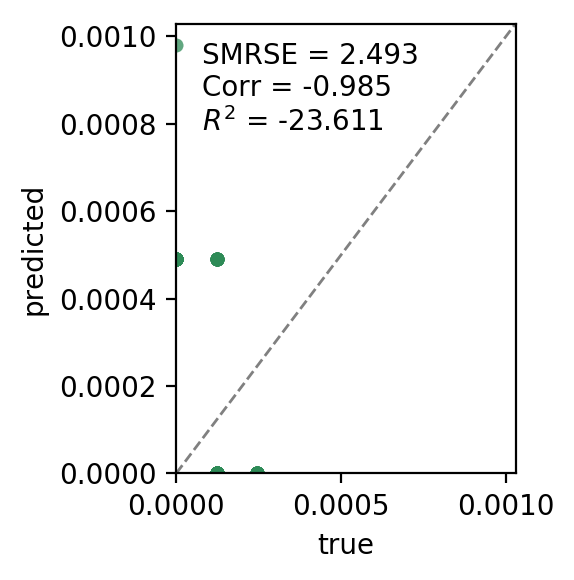

data_space_size = 10151
{'mae': 0.00019656616463943472, 'rmse': 0.0002455925172485509, 'r2': -23.61109570160385, 'srmse': 2.49300964259004, 'corr': -0.985203561166786}
--------------------------------------------------------------------------------
Took 0.28441715240478516 seconds to compare_joints_bins
nearest_samples_dist loaded from file: model_cache/data_train/data_train/nearest_samples_dist--samples_train--freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--0.pickle
nearest_samples_ind loaded from file: model_cache/data_train/data_train/nearest_samples_ind--samples_train--freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--0.pickle
nearest_samples_dist = {'mean': 2.210974260643268, 'stddev': 2.0752819715715867, 'frac0': 0.0, 'dist': array([ 2.5704478 ,  1.43267312,  2.00107424, ..., 10.79046686,
        0.65295013,  2.16443652]), 'ind': array([1880,  954,  998, ..., 1304,  817,  140])}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
m

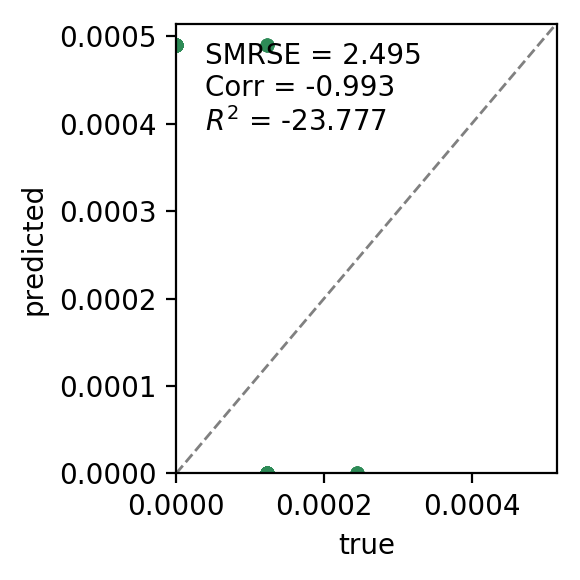

data_space_size = 10176
{'mae': 0.00019630002158095943, 'rmse': 0.00024523047584238983, 'r2': -23.776788582442293, 'srmse': 2.495465322172159, 'corr': -0.9926989845105415}
--------------------------------------------------------------------------------
Took 0.6359601020812988 seconds to compare_joints_bins
nearest_samples_dist loaded from file: model_cache/data_train/data_train/nearest_samples_dist--samples_train--freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--0.pickle
nearest_samples_ind loaded from file: model_cache/data_train/data_train/nearest_samples_ind--samples_train--freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--0.pickle
nearest_samples_dist = {'mean': 2.210974260643268, 'stddev': 2.0752819715715867, 'frac0': 0.0, 'dist': array([ 2.5704478 ,  1.43267312,  2.00107424, ..., 10.79046686,
        0.65295013,  2.16443652]), 'ind': array([1880,  954,  998, ..., 1304,  817,  140])}
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [109]:
# performance for all atributes
stat_train = get_stat(data_test, {samples_train_keys[0]: data_train},
                      data_test, bin_n_comparisons,
                      samples_true_cache_dir, samples_pred_cache_dir,
                     )

--------------------------------------------------------------------------------
bin_n_comparison = scheme_1
model min = 2.49300964259004


/Users/fredshone/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


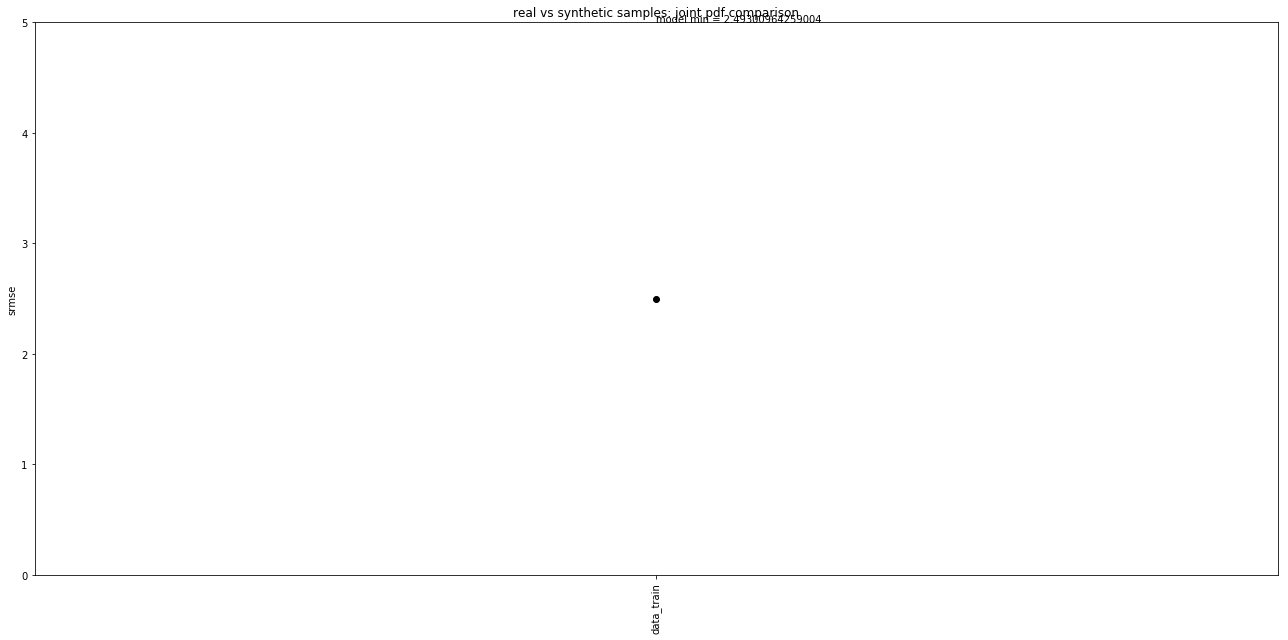

model min = 2.210974260643268


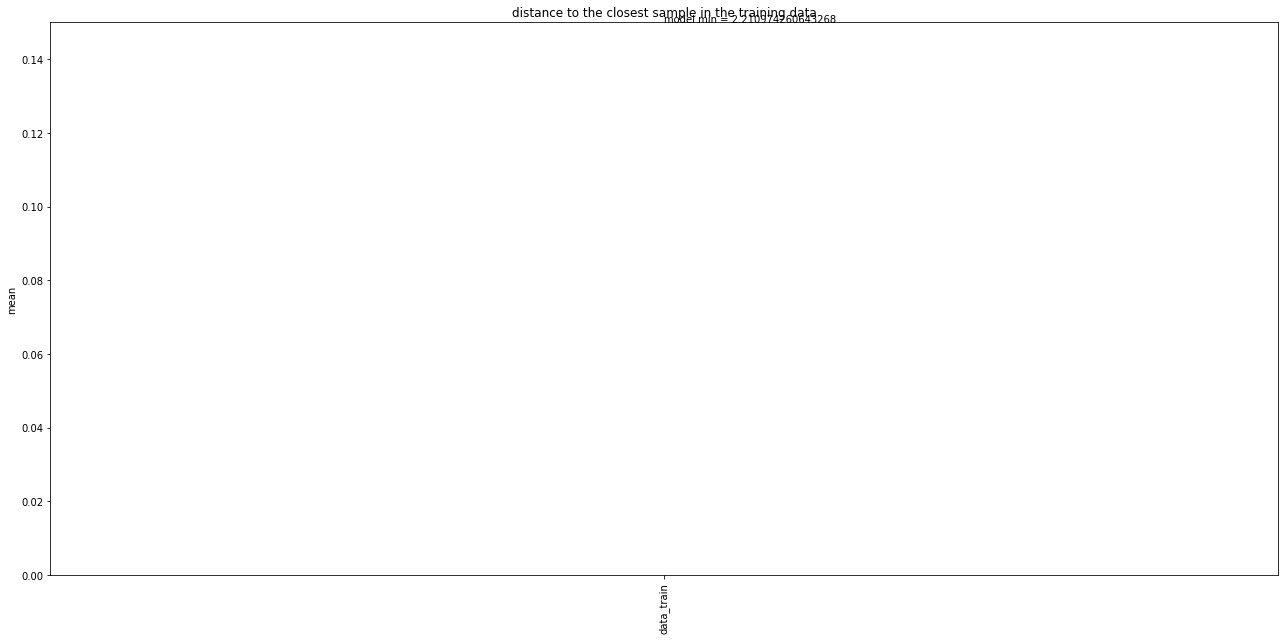

model min = 2.0752819715715867


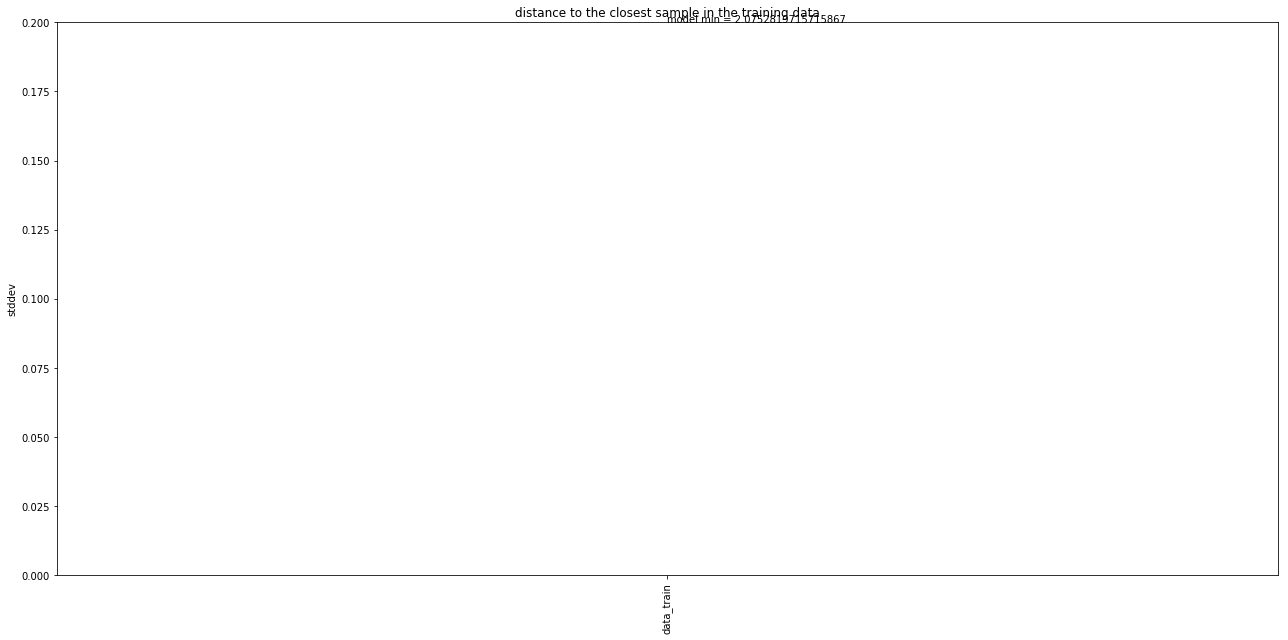

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
bin_n_comparison = 10
model min = 2.495465322172159


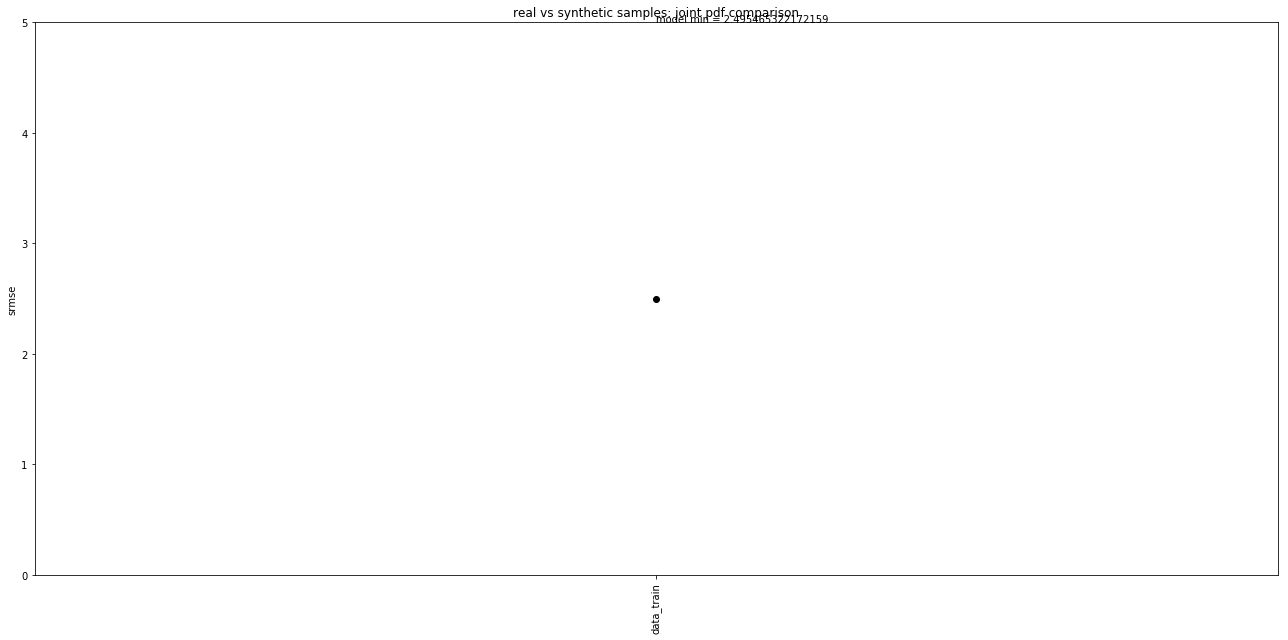

model min = 2.210974260643268


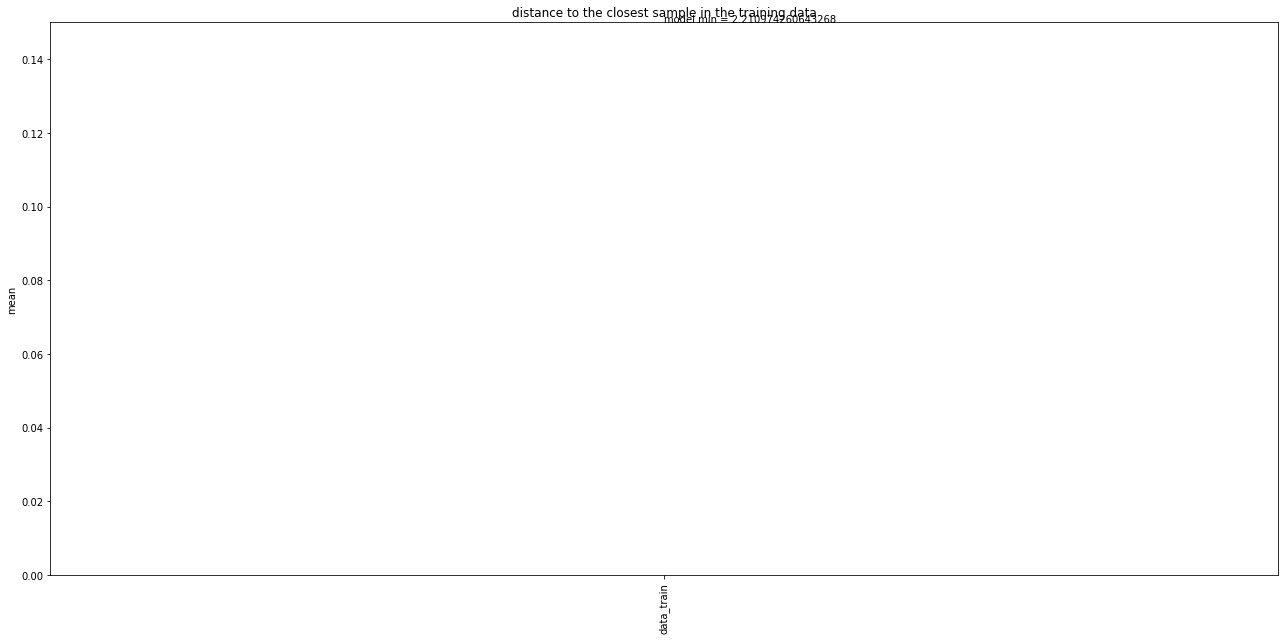

model min = 2.0752819715715867


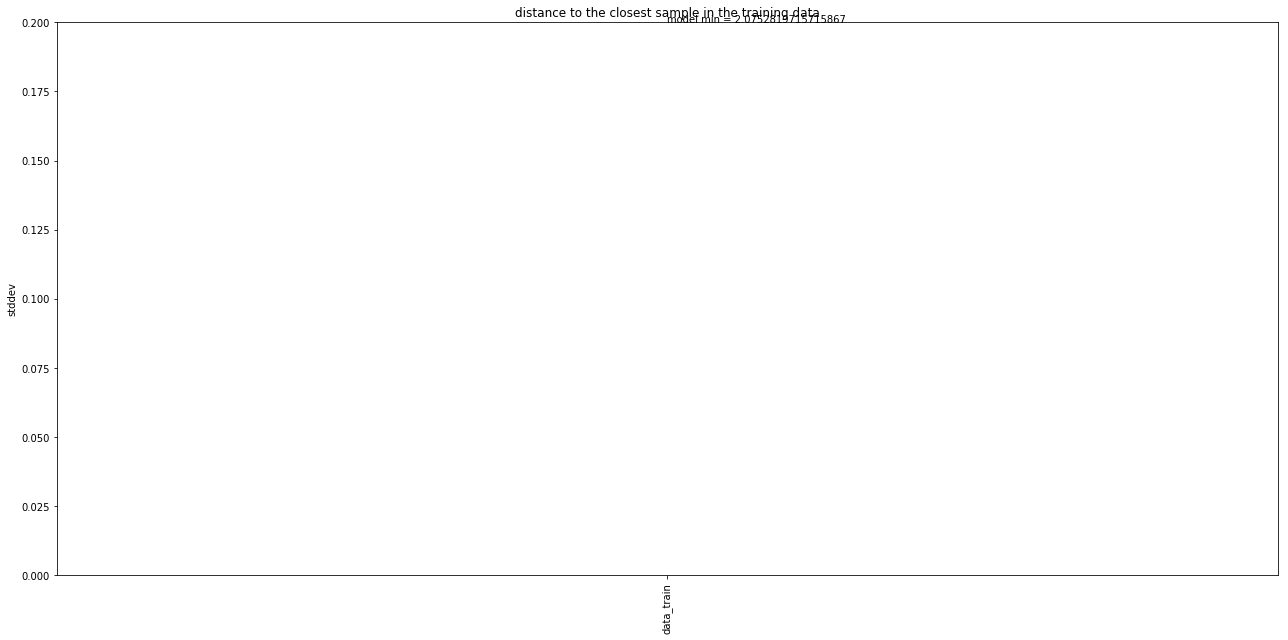

--------------------------------------------------------------------------------


In [110]:
# performance for all atributes
(errors_train, 
 diversity_1_train, 
 diversity_2_train,
 xticks_train) = get_perform_plot_data(stat_train, bin_n_comparisons, samples_train_keys)

model_cache/data_test/freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--bin_n_c=scheme_1--0.pickle
model_cache/data_test/freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--bin_n_c=scheme_1--0.pickle
data_freq loaded from file: model_cache/data_test/freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--bin_n_c=scheme_1--0.pickle
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
bin_n_c = scheme_1
samples: data_train
Calculating 1 out of 2
model_cache/data_train/data_train/freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--bin_n_c=scheme_1--0.pickle
data_freq loaded from file: model_cache/data_train/data_train/freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--bin_n_c=scheme_1--0.pickle
--------------------------------------------------------------------------------
numerical var bins_n = scheme_1
corr = -0.985204
MAE = 0.000197
RMSE = 0.000246
SRMSE = 2.493010
r2 = -23.611096


/Users/fredshone/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


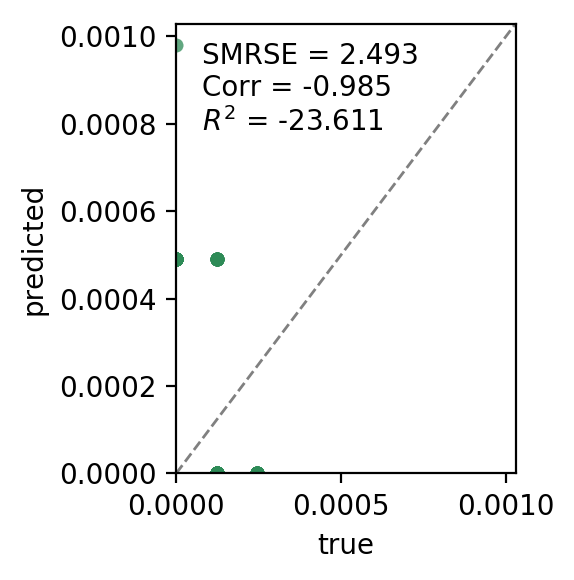

data_space_size = 10151
{'mae': 0.00019656616463943472, 'rmse': 0.0002455925172485509, 'r2': -23.61109570160385, 'srmse': 2.49300964259004, 'corr': -0.985203561166786}
--------------------------------------------------------------------------------
Took 0.29723501205444336 seconds to compare_joints_bins
nearest_samples_dist loaded from file: model_cache/data_train/data_train/nearest_samples_dist--samples_train--freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--0.pickle
nearest_samples_ind loaded from file: model_cache/data_train/data_train/nearest_samples_ind--samples_train--freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--0.pickle
nearest_samples_dist = {'mean': 2.210974260643268, 'stddev': 2.0752819715715867, 'frac0': 0.0, 'dist': array([ 2.5704478 ,  1.43267312,  2.00107424, ..., 10.79046686,
        0.65295013,  2.16443652]), 'ind': array([1880,  954,  998, ..., 1304,  817,  140])}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
m

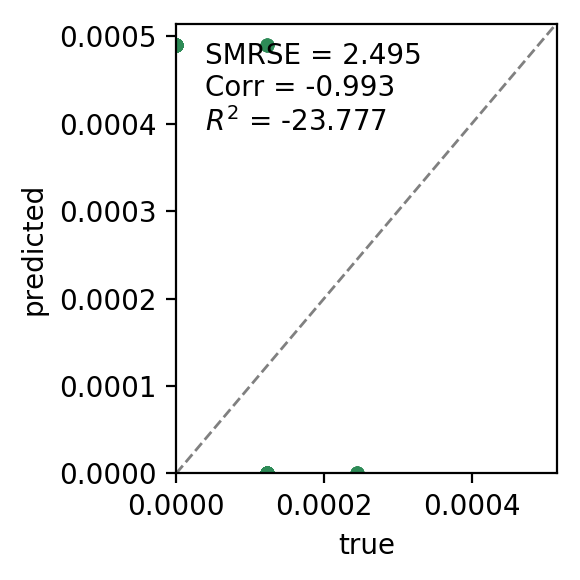

data_space_size = 10176
{'mae': 0.00019630002158095943, 'rmse': 0.00024523047584238983, 'r2': -23.776788582442293, 'srmse': 2.495465322172159, 'corr': -0.9926989845105415}
--------------------------------------------------------------------------------
Took 0.26718688011169434 seconds to compare_joints_bins
nearest_samples_dist loaded from file: model_cache/data_train/data_train/nearest_samples_dist--samples_train--freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--0.pickle
nearest_samples_ind loaded from file: model_cache/data_train/data_train/nearest_samples_ind--samples_train--freq_cache_file--var_is_ignore=None--var_g_is_ignore=None--0.pickle
nearest_samples_dist = {'mean': 2.210974260643268, 'stddev': 2.0752819715715867, 'frac0': 0.0, 'dist': array([ 2.5704478 ,  1.43267312,  2.00107424, ..., 10.79046686,
        0.65295013,  2.16443652]), 'ind': array([1880,  954,  998, ..., 1304,  817,  140])}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [111]:
# performance for the selected atributes
stat_train_selected = get_stat(data_test, {samples_train_keys[0]: data_train}, 
                               data_test, bin_n_comparisons, 
                               samples_true_cache_dir, samples_pred_cache_dir,
                               var_is_ignore, var_g_is_ignore)

--------------------------------------------------------------------------------
bin_n_comparison = scheme_1
model min = 2.49300964259004


/Users/fredshone/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


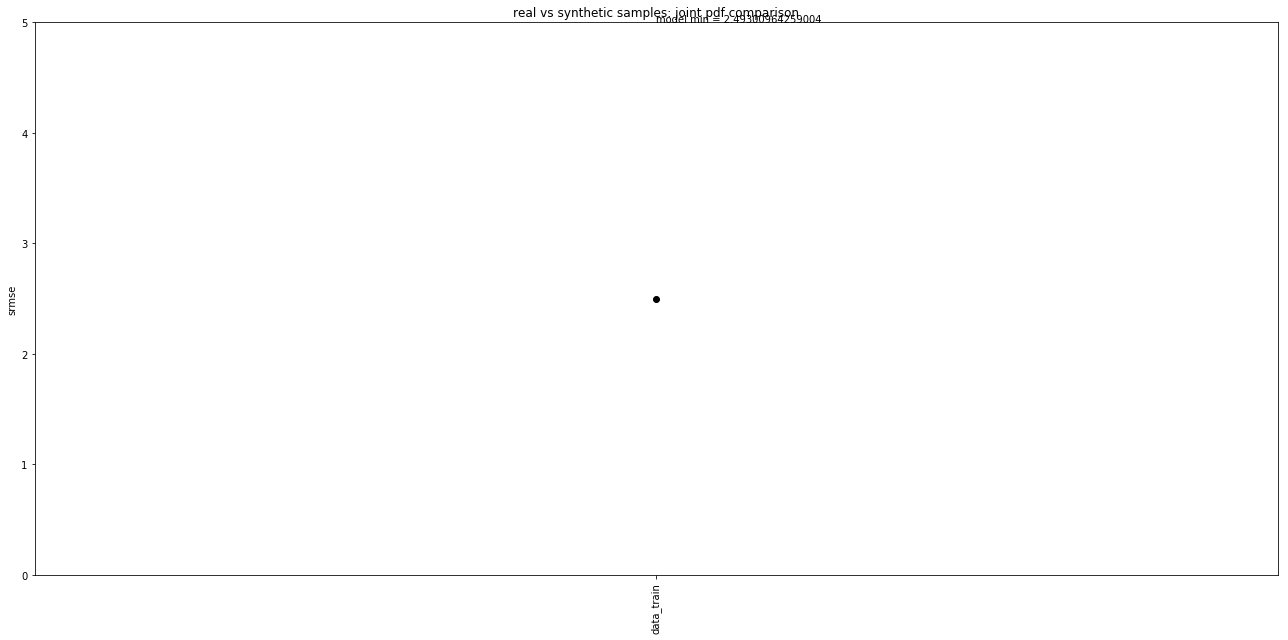

model min = 2.210974260643268


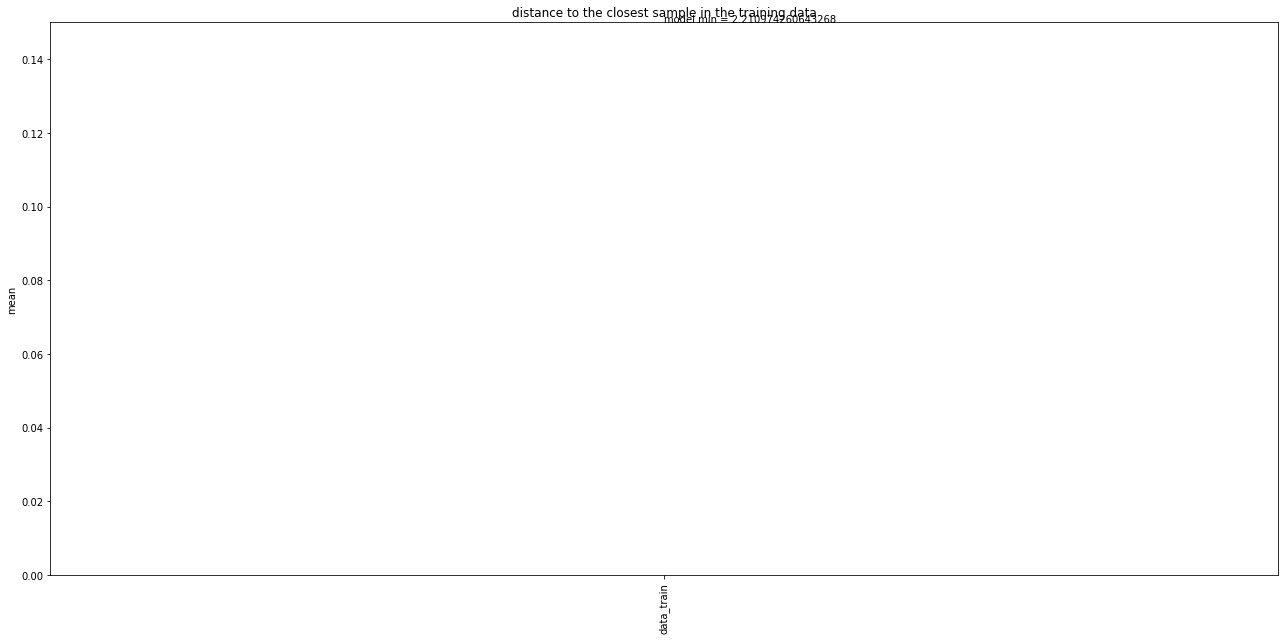

model min = 2.0752819715715867


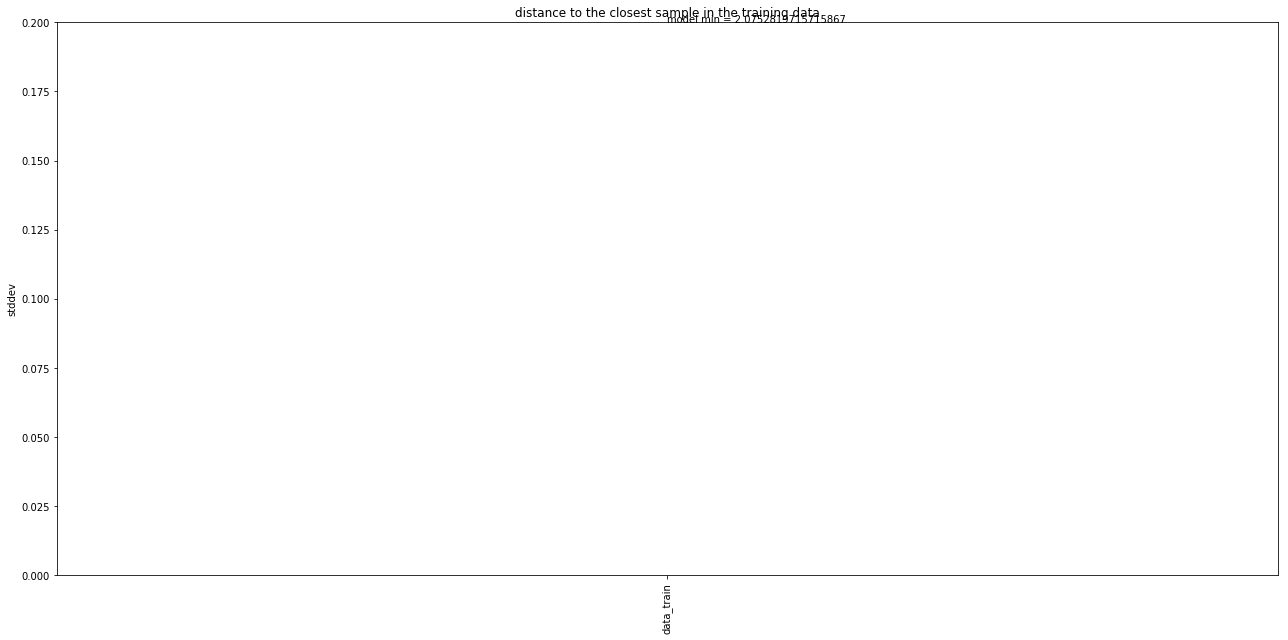

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
bin_n_comparison = 10
model min = 2.495465322172159


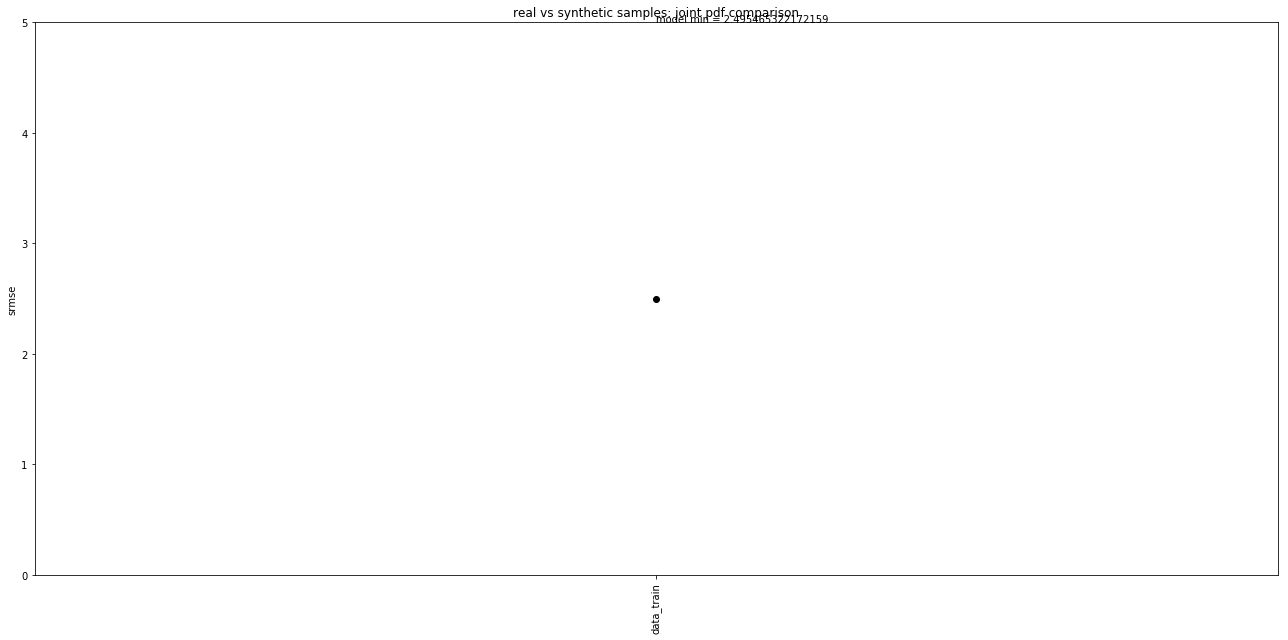

model min = 2.210974260643268


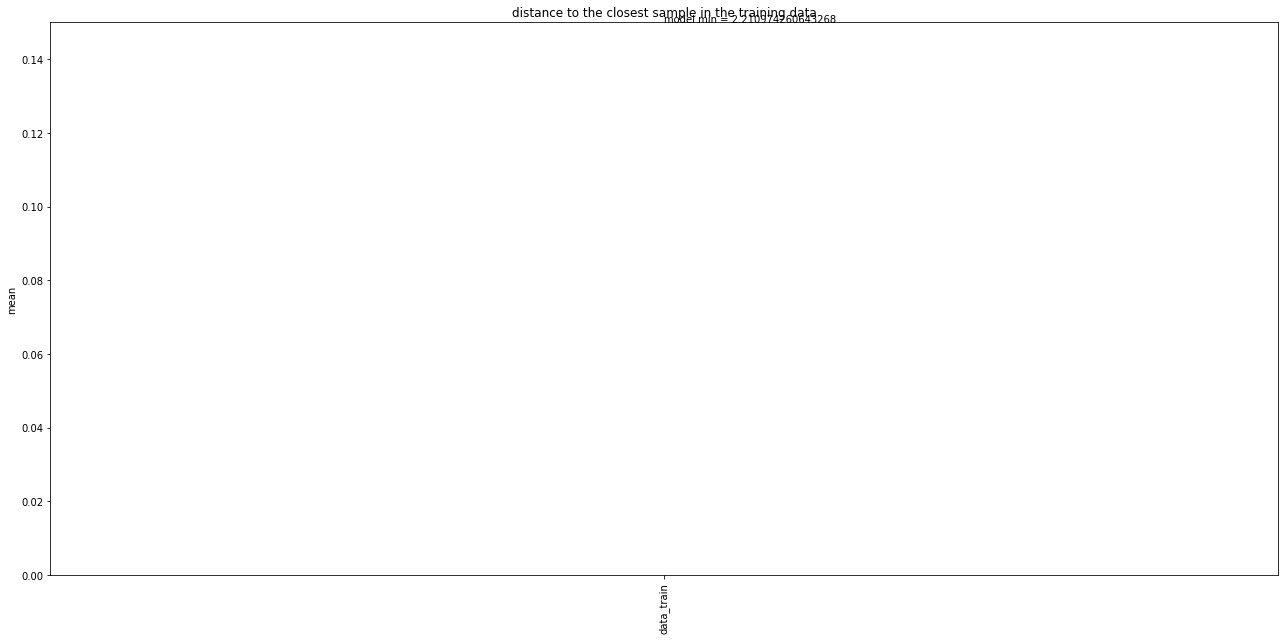

model min = 2.0752819715715867


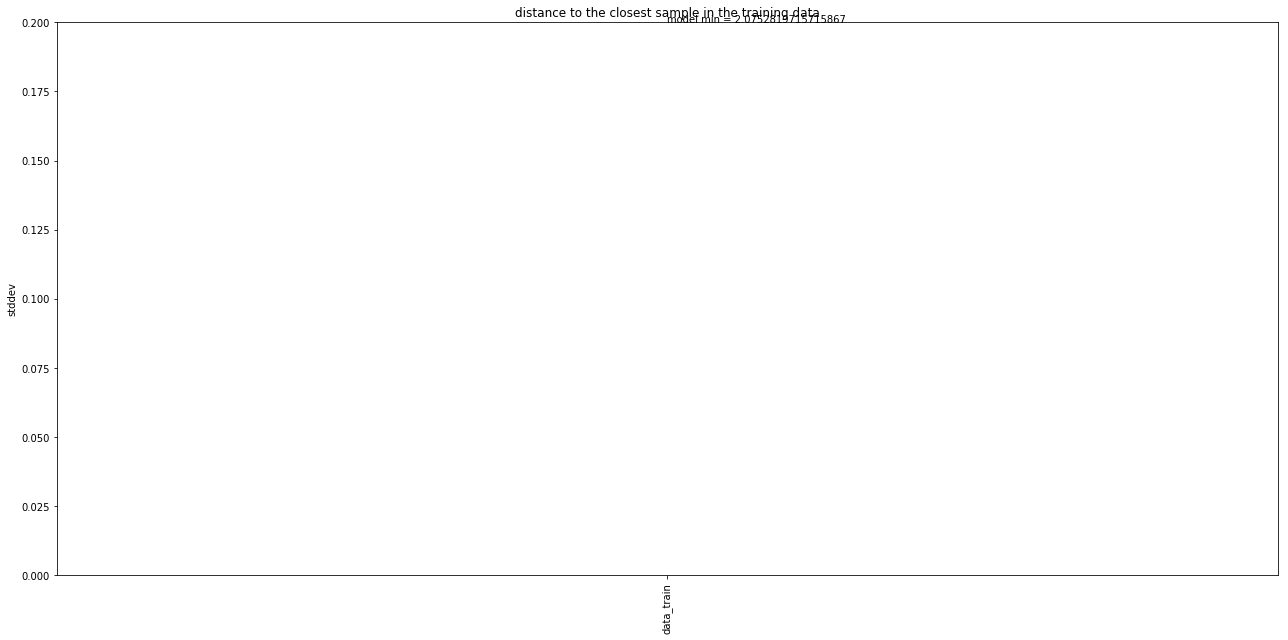

--------------------------------------------------------------------------------


In [112]:
# performance for the selected atributes
(errors_train_selected, 
 diversity_1_train_selected, 
 diversity_2_train_selected,
 xticks_train_selected) = get_perform_plot_data(stat_train_selected, 
                                            bin_n_comparisons, 
                                            samples_train_keys)

# VAE

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, Layer, Reshape, BatchNormalization, Flatten, Concatenate
from keras.models import Model
from keras import backend as K
from keras import metrics, losses
from keras import optimizers
from sklearn.preprocessing import StandardScaler

In [114]:
# updatable plot for the training

from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []        
        self.fig = plt.figure()        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        m1, m2 = 'loss', 'val_loss'
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get(m1))
        self.val_losses.append(logs.get(m2))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label=m1)
        plt.plot(self.x, self.val_losses, label=m2)
        plt.legend()
        plt.show();
        
plot_learning = PlotLosses()

In [119]:
# Hyperparameters grid
activation_grid = ['tanh'] # ANN activation
cat_loss_weight_grid = [1.0] # weight of the categorical loss term
beta_grid = [0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 100.0] # weight of the KL loss term
latent_dim_grid = [5, 10, 25] # latent dimensionality
hidden_layers_shape_grid = [
    [100, 50, 25], [100, 50], [100], [50, 25], [50], [25]
] # number of neurons in hidden layers [neurons_number_hidden_layer_1, neurons_number_hidden_layer_2, ...]
if numerical_col_n == 0 or categorical_col_n == 0:
    cat_loss_weight_grid = [1.0]
# number of epochs and mini-batch size
epochs = 100
batch_size = 64
# number of samples from VAE
n_samples = 100000
# train / development set (to tune hyperparameters) ratio
train_dev_ratio = 0.8
samples_dev_cache_dir = os.path.join(model_cache_dir, 'data_dev_{}-{}'.format(train_dev_ratio, file_suffix))
#
pprint(cat_loss_weight_grid)
pprint(beta_grid)
pprint(latent_dim_grid)
pprint(hidden_layers_shape_grid)
pprint(activation_grid)
print(len(cat_loss_weight_grid) * len(beta_grid) * len(latent_dim_grid) 
      * len(hidden_layers_shape_grid) * len(activation_grid))

[1.0]
[0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 100.0]
[5, 10, 25]
[[100, 50, 25], [100, 50], [100], [50, 25], [50], [25]]
['tanh']
126


In [120]:
# train VAE
# ! a lot of global variables, like data_train, numerical_col_n, etc, are used !
# ...like probably everywhere in this code :(
def vae_train(cat_loss_weight, beta, activation, latent_dim, hidden_layers_shape):
    # split data
    train_dev_ind = int(len(data_train) * train_dev_ratio)
    data_train_01 = copy.deepcopy(data_train[:train_dev_ind])
    data_test_01 = copy.deepcopy(data_train[train_dev_ind:])
    # scale numerical variables to N(0, 1)
    if numerical_col_n > 0:
        scaler = StandardScaler()
        scaler = scaler.fit(data_train[:, :numerical_col_n])
        data_train_01[:, :numerical_col_n] = scaler.transform(
            data_train_01[:, :numerical_col_n])
        data_test_01[:, :numerical_col_n] = scaler.transform(
            data_test_01[:, :numerical_col_n])
    else:
        scaler = None
    #
    original_dim = features_n
    # specify optimizer
    optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    # encoder
    x = Input(shape=(original_dim,))
    h = x
    for hl_shape in hidden_layers_shape:
        h = Dense(hl_shape, activation=activation)(h)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)
    # reparameterization
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    z = Lambda(sampling)([z_mean, z_log_var])
    # decoder
    
    
    
    decoder_h = [Dense(hl_shape, activation=activation) for hl_shape in reversed(hidden_layers_shape)]
    if numerical_col_n > 0:
        x_decoder_mean_num = Dense(numerical_col_n)
    if categorical_col_n > 0:
        x_decoder_mean_cat = [Dense(cat_groups[g_i + 1] - cat_groups[g_i], activation='softmax') 
                              for g_i in range(cat_groups_n)]
    h_decoded = decoder_h[0](z)
    for decoder_h_ in decoder_h[1:]:
        h_decoded = decoder_h_(h_decoded)
    if numerical_col_n > 0:
        x_decoded_mean_num = x_decoder_mean_num(h_decoded)
    if categorical_col_n > 0:
        x_decoded_mean_cat = [x_decoder_mean_cat_(h_decoded)
                              for x_decoder_mean_cat_ in x_decoder_mean_cat]
    if numerical_col_n > 0 and categorical_col_n > 0:
        x_decoded_mean = Concatenate()([x_decoded_mean_num] + x_decoded_mean_cat)
    elif numerical_col_n > 0:
        x_decoded_mean = x_decoded_mean_num
    elif categorical_col_n > 0:
        x_decoded_mean = Concatenate()(x_decoded_mean_cat)
    else:
        raise Exception("NO FEATURES")
    # custom losses
    # total loss (used as loss in model.compile below)
    def vae_loss(y_true, y_pred):
        # numerical loss
        recon_num = 0
        if numerical_col_n > 0:
            recon_num = K.sum(K.square(y_pred[:, :numerical_col_n] - y_true[:, :numerical_col_n]), axis=-1)
        # categorical loss
        recon_cat = 0
        for g_i in range(cat_groups_n):    
            g_i_beg = cat_groups[g_i]
            g_i_end = cat_groups[g_i + 1]
            recon_cat += metrics.categorical_crossentropy(y_true[:, g_i_beg:g_i_end], y_pred[:, g_i_beg:g_i_end])
        # KL loss
        kl = - 0.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        # total loss
        loss = K.mean(recon_num + recon_cat * cat_loss_weight + beta * kl)
        return loss
    # KL loss (used as metrics in model.compile below)
    def KL_loss(y_true, y_pred):
        kl = - 0.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(beta * kl)
    # numerical loss (used as metrics in model.compile below)
    def recon_loss_num(y_true, y_pred):
        recon_num = 0
        if numerical_col_n > 0:
            recon_num = K.sum(K.square(y_pred[:, :numerical_col_n] - y_true[:, :numerical_col_n]), axis=-1)
        return K.mean(recon_num)
    # categorical loss (used as metrics in model.compile below)
    def recon_loss_cat(y_true, y_pred):
        recon_cat = 0
        for g_i in range(cat_groups_n):    
            g_i_beg = cat_groups[g_i]
            g_i_end = cat_groups[g_i + 1]
            recon_cat += metrics.categorical_crossentropy(y_true[:, g_i_beg:g_i_end], y_pred[:, g_i_beg:g_i_end])
        return K.mean(recon_cat * cat_loss_weight)
    # build a VAE model (encoder+decoder)
    model = Model(x, x_decoded_mean)
    # Run training
    if numerical_col_n > 0 and categorical_col_n > 0:
        model.compile(optimizer=optimizer, loss=vae_loss, metrics=[KL_loss, recon_loss_num, recon_loss_cat])
    elif numerical_col_n > 0:
        model.compile(optimizer=optimizer, loss=vae_loss, metrics=[KL_loss, recon_loss_num])
    elif categorical_col_n > 0:
        model.compile(optimizer=optimizer, loss=vae_loss, metrics=[KL_loss, recon_loss_cat])
    else:
        raise Exception("NO FEATURES")
    model.fit(data_train_01, data_train_01,
              shuffle=True,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(data_test_01, data_test_01),
              callbacks=[plot_learning],
             )
    # build a model to project inputs on the latent space (encoder only)
    encoder = Model(x, z_mean)
    # display a 2D plot to check the latent space embedding of the training data
    x_train_encoded = encoder.predict(data_train_01, batch_size=batch_size)
    # dummy labels are used
    labels = [sum(np.count_nonzero(a) for a in x) for x in data_train_01]
    plt.figure(figsize=(6, 6))
    plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], c=labels, alpha=0.05)
    plt.colorbar()
    plt.show()
    # define a sampling model (decoder only)
    z_sample = Input(shape=(latent_dim,))
    h_decoded_sample = decoder_h[0](z_sample)
    for decoder_h_ in decoder_h[1:]:
        h_decoded_sample = decoder_h_(h_decoded_sample)
    if numerical_col_n > 0:
        x_decoded_sample_num = x_decoder_mean_num(h_decoded_sample)
    if categorical_col_n > 0:
        x_decoded_sample_cat = [x_decoder_mean_cat_(h_decoded_sample)
                                for x_decoder_mean_cat_ in x_decoder_mean_cat]
    if numerical_col_n > 0 and categorical_col_n > 0:
        x_decoded_sample = Concatenate()([x_decoded_sample_num] + x_decoded_sample_cat)
    elif numerical_col_n > 0:
        x_decoded_sample = x_decoded_sample_num
    elif categorical_col_n > 0:
        x_decoded_sample = Concatenate()(x_decoded_sample_cat)
    else:
        raise Exception("NO FEATURES")
    # biuld the sampling model
    model_sample = Model(z_sample, x_decoded_sample)
    # the full VAE model is not saved
    return model_sample, scaler

In [117]:
# get samples from VAE
def vae_get_samples(model_sample, n_samples, scaler):
    z_sample = np.random.normal(0., 1.0, size=(n_samples, latent_dim))
    samples = model_sample.predict(z_sample)
    # scale back
    if numerical_col_n > 0:
        samples[:, :numerical_col_n] = scaler.inverse_transform(samples[:, :numerical_col_n])
    # back from categorical softmax to one-hot
    for g_i in range(cat_groups_n):
        g_i_beg = cat_groups[g_i]
        g_i_end = cat_groups[g_i + 1]
        data_pred_col = samples[:, g_i_beg:g_i_end]
        data_pred_col = np.argmax(data_pred_col, axis=1)
        for row_i, row in enumerate(samples):
            for col_i in range(g_i_beg, g_i_end):
                if col_i - g_i_beg != data_pred_col[row_i]:
                    samples[row_i, col_i] = 0
                else:
                    samples[row_i, col_i] = 1
    # deal with the integer variables and clip using min/max values
    if numerical_col_n > 0:
        min_max_scheme = 'scheme_1'
        col_names_num = df.columns.tolist()[:numerical_col_n]
        for col_ind, col_name in enumerate(col_names_num):
            if col_name in numerical_int:
                samples[:, col_ind] = np.around(samples[:, col_ind])
            # 
            samples[:, col_ind] = np.clip(samples[:, col_ind], 
                                    min_max_bins[min_max_scheme][col_name][0], 
                                    min_max_bins[min_max_scheme][col_name][1])
    return samples

In [118]:
# training VAE for the hyperparameters grid + caching
train_models = True # if False then just load all pretrained models
vae_model_cache_dirname = 'vae--epochs={}--batch_size={}'.format(epochs, batch_size) # cache folder
#
vae_model_cache_dir = os.path.join(model_cache_dir, vae_model_cache_dirname)
if not os.path.exists(vae_model_cache_dir): 
    os.makedirs(vae_model_cache_dir)
if train_models: # get combinations of hyperparameters
    model_cache_files_vae, model_parameters_vae = [], []
    for cat_loss_weight in cat_loss_weight_grid:
        for beta in beta_grid:
            for activation in activation_grid:
                for latent_dim in latent_dim_grid:
                    for hidden_layers_shape in hidden_layers_shape_grid:
                        model_cache_filename = 'model'
                        if beta != 1.0:
                            model_cache_filename += '--' + 'beta=' + str(beta).replace('.', ',') 
                        if cat_loss_weight != 1.0:
                            model_cache_filename += '--' + 'clw=' + str(cat_loss_weight).replace('.', ',') 
                        model_cache_filename += '--' + 'activation=' + str(activation) 
                        model_cache_filename += '--' + 'latent_dim=' + str(latent_dim)
                        model_cache_filename += '--' + 'hidden_layers_shape=' + str(hidden_layers_shape) 
                        model_cache_filename += '--' + file_suffix + '.h5'
                        model_cache_files_vae.append(model_cache_filename)
                        model_parameters_vae.append((cat_loss_weight, beta, 
                                                     activation, latent_dim, hidden_layers_shape))
else: # just load all pretrained models
    import glob, os
    cwd = os.getcwd()
    filename_patten = "model*--" + file_suffix + ".h5"
    model_cache_files_vae = list(glob.glob(os.path.join(cwd, vae_model_cache_dir, filename_patten)))
    model_cache_files_vae = [os.path.split(x)[1] for x in model_cache_files_vae]
# number of models
n_calc = len(model_cache_files_vae)
print("len(model_cache_files_vae) =", len(model_cache_files_vae))
# iterate through the models
samples_vae = {}
for i, model_cache_filename in enumerate(model_cache_files_vae):
    # get a model
    scaler_cache_filename = 'scaler_' + model_cache_filename
    model_cache_file = os.path.join(vae_model_cache_dir, model_cache_filename)
    scaler_cache_file = os.path.join(vae_model_cache_dir, scaler_cache_filename)
    print("model_cache_filename:", model_cache_filename)
    if train_models:
        is_model_cache_file = os.path.isfile(model_cache_file)            
        # It is not recommended to use pickle or cPickle to save a Keras model
        if is_model_cache_file:
            model_sample = keras.models.load_model(model_cache_file)
            with open(scaler_cache_file, 'rb') as f:
                scaler = pickle.load(f)
            print('model loaded from file: ' + model_cache_file)
        else:
            print('training model')
            start = time.time()
            model_sample, scaler = vae_train(*model_parameters_vae[i])
            duration = time.time() - start
            print(model_cache_filename)
            print("Took {} seconds to train vae".format(duration))
            print("Trained model {} out of {}".format(i + 1, n_calc))
            model_sample.save(model_cache_file)
            with open(scaler_cache_file, 'wb') as f:
                pickle.dump(scaler, f)
            print('model saved to file: ' + model_cache_file)
    # generate samples
    samples_cache_filename = 'samples'
    samples_cache_filename += '--' + model_cache_filename
    samples_cache_filename += '--n_samples=' + str(n_samples)
    samples_cache_filename += '--' + file_suffix + '.pickle'
    samples_cache_file = os.path.join(vae_model_cache_dir, samples_cache_filename)
    print("samples_cache_filename:", samples_cache_filename)
    is_samples_cache_file = os.path.isfile(samples_cache_file)
    if is_samples_cache_file:
        with open(samples_cache_file, 'rb') as f:
            samples_vae[model_cache_filename] = pickle.load(f)
        print('samples loaded from file')
    else:
        print('generating samples')
        samples_vae[model_cache_filename] = vae_get_samples(model_sample, n_samples, scaler)
        with open(samples_cache_file, 'wb') as f:
            pickle.dump(samples_vae[model_cache_filename], f)
        print('samples saved to file')
    print(80 * '-')

len(model_cache_files_vae) = 126
model_cache_filename: model--beta=0,01--activation=tanh--latent_dim=5--hidden_layers_shape=[100, 50, 25]--0.h5
training model


ValueError: Duplicate node name in graph: 'lambda_2/random_normal/shape'

In [ ]:
# performance for all atributes (development set)
stat_vae_dev = get_stat(data_train[train_dev_ind:], samples_vae, data_train, bin_n_comparisons,
                        samples_dev_cache_dir, vae_model_cache_dir)

In [ ]:
# performance for all atributes (development set)
(errors_vae_dev, 
 diversity_1_vae_dev, 
 diversity_2_vae_dev,
 xticks_vae_dev) = get_perform_plot_data(stat_vae_dev, bin_n_comparisons, model_cache_files_vae, True)

In [ ]:
# performance for the selected atributes (development set)
stat_vae_dev_selected = get_stat(data_train[train_dev_ind:], samples_vae, data_train, bin_n_comparisons,
                                 samples_dev_cache_dir, vae_model_cache_dir,
                                 var_is_ignore, var_g_is_ignore)

In [ ]:
# performance for the selected atributes (development set)
(errors_vae_dev_selected, 
 diversity_1_vae_dev_selected, 
 diversity_2_vae_dev_selected,
 xticks_vae_dev_selected) = get_perform_plot_data(stat_vae_dev_selected, bin_n_comparisons, 
                                                  model_cache_files_vae, True)

In [ ]:
# performance for all atributes (test set)
stat_vae = get_stat(data_test, samples_vae, data_train, bin_n_comparisons,
                    samples_true_cache_dir, vae_model_cache_dir)

In [ ]:
# performance for all atributes (test set)
(errors_vae, 
 diversity_1_vae, 
 diversity_2_vae,
 xticks_vae) = get_perform_plot_data(stat_vae, bin_n_comparisons, model_cache_files_vae, True)

In [ ]:
# performance for the selected atributes (test set)
stat_vae_selected = get_stat(data_test, samples_vae, data_train, bin_n_comparisons,
                             samples_true_cache_dir, vae_model_cache_dir,
                             var_is_ignore, var_g_is_ignore)

In [ ]:
# performance for the selected atributes (test set)
(errors_vae_selected, 
 diversity_1_vae_selected, 
 diversity_2_vae_selected,
 xticks_vae_selected) = get_perform_plot_data(stat_vae_selected, bin_n_comparisons, 
                                              model_cache_files_vae, True)

In [ ]:
# plot marginals
for k in model_cache_files_vae:
    print(80 * '-')
    print(k)
    check_marginals_numerical([data_train, samples_vae[k]], bin_n_comparisons)
    check_marginals_categorical([data_train, samples_vae[k]])   
    print(80 * '-')
    break

# MCMC (Gibbs) Full Conditional Baseline: p(x\_i | x\_-i)

In [ ]:
# get samples from a single starting point
def full_cond_get_samples(full_cond, num_bin, n_samples):
    print('full cond bin_n={}: generating {} samples'.format(num_bin, n_samples))
    #
    samples_cond = []
    #
    if num_bin in min_max_bins:
        min_max_num_bin = min_max_bins[num_bin]
    else:
        min_max_num_bin = calc_min_max_num_bin(data_train, num_bin)
    #
    idx = np.random.randint(len(data_train))
    sample = data_train[idx]
    for i in range(burn_out + n_samples * thinning):
        if i % 1000 == 0: print(i)
        for var_i in range(numerical_col_n):
            var_name = 'num' + str(var_i)
            bin_key = get_bin_key(sample, min_max_num_bin, [var_i], None)
            if bin_key in full_cond[var_name]:
                val_i = np.random.randint(len(full_cond[var_name][bin_key]))
                sample[var_i] = full_cond[var_name][bin_key][val_i]
            else:
                print("empty bin")
        for var_g_i in range(cat_groups_n):
            var_name = 'cat' + str(var_g_i)
            var_g_i_beg = cat_groups[var_g_i]
            var_g_i_end = cat_groups[var_g_i + 1]
            bin_key = get_bin_key(sample, min_max_num_bin, None, [var_g_i])
            if bin_key in full_cond[var_name]:
                val_i = np.random.randint(len(full_cond[var_name][bin_key]))
                sample[var_g_i_beg: var_g_i_end] = full_cond[var_name][bin_key][val_i]
            else:
                print("empty bin")
        if i >= burn_out and (i - burn_out) % thinning == 0:
            samples_cond.append(copy.deepcopy(sample))
    samples_cond = np.array(samples_cond)
    return samples_cond


# get samples from several starting points
def full_cond_get_samples_over_x0(full_cond, num_bin, n_samples):
    print('full cond bin_n={}: generating {} samples'.format(num_bin, n_samples))
    #
    samples_cond = []
    print_time_per_sample = True
    #
    if num_bin in min_max_bins:
        min_max_num_bin = min_max_bins[num_bin]
    else:
        min_max_num_bin = calc_min_max_num_bin(data_train, num_bin)
    #
    for n_sample in range(n_samples):
        if print_time_per_sample:
            start = time.time()
        if n_sample % 100 == 0: 
            print('n_sample =', n_sample)
        idx = np.random.randint(len(data_train))
        sample = data_train[idx]
        for i in range(burn_out):
            for var_i in range(numerical_col_n):
                var_name = 'num' + str(var_i)
                bin_key = get_bin_key(sample, min_max_num_bin, [var_i], None)
                if bin_key in full_cond[var_name]:
                    val_i = np.random.randint(len(full_cond[var_name][bin_key]))
                    sample[var_i] = full_cond[var_name][bin_key][val_i]
                else:
                    #print("n_sample={}, step i={}: empty bin (num)".format(n_sample, i))
                    pass
            for var_g_i in range(cat_groups_n):
                var_name = 'cat' + str(var_g_i)
                var_g_i_beg = cat_groups[var_g_i]
                var_g_i_end = cat_groups[var_g_i + 1]
                bin_key = get_bin_key(sample, min_max_num_bin, None, [var_g_i])
                if bin_key in full_cond[var_name]:
                    val_i = np.random.randint(len(full_cond[var_name][bin_key]))
                    sample[var_g_i_beg: var_g_i_end] = full_cond[var_name][bin_key][val_i]
                else:
                    #print("n_sample={}, step i={}: empty bin (cat)".format(n_sample, i))
                    pass
        samples_cond.append(copy.deepcopy(sample))
        if print_time_per_sample:
            duration = time.time() - start
            print("Took {} seconds to get one sample".format(duration))
            print_time_per_sample = False
    samples_cond = np.array(samples_cond)
    return samples_cond

In [ ]:
# parameters of the Gibbs sampler
calc_over_x0 = False
if calc_over_x0:
    n_samples = 1000 # it is very computationally expencive
    burn_out = 10000
    thinning = -1
else:
    n_samples = 100000
    burn_out = 20000
    thinning = 20    
full_cond_model_cache_dir = os.path.join(model_cache_dir, 'full_cond')
if not os.path.exists(full_cond_model_cache_dir): 
    os.makedirs(full_cond_model_cache_dir)

In [ ]:
# calculate sampling probabilits for numerical variables using 1) scheme_1 in min_max_bins, 2) 10 uniform bins
bin_ns_cond = ['scheme_1', 10]
#
samples_cond = {}
for bin_n in bin_ns_cond:
    # get model
    model_cache_file = 'model_bin_n=' + str(bin_n) + '--' + file_suffix + '.pickle'
    model_cache_file = os.path.join(full_cond_model_cache_dir, model_cache_file)
    print("full cond cache file:", model_cache_file)
    is_model_cache_file = os.path.isfile(model_cache_file)
    if is_model_cache_file:
        with open(model_cache_file, 'rb') as f:
            full_cond = pickle.load(f)
        print("full cond loaded from file")
    else:
        print("calculating full cond")
        start = time.time()
        full_cond = calc_full_conditionals(data_train, bin_n)
        duration = time.time() - start
        print("Took {} seconds to calculate full cond".format(duration))
        with open(model_cache_file, 'wb') as f:
            pickle.dump(full_cond, f)
    # generate samples
    samples_cache_file = 'samples_bin_n=' + str(bin_n)
    samples_cache_file += '--n_samples=' + str(n_samples)
    samples_cache_file += '--burn_out=' + str(burn_out)
    if thinning >= 0:
        samples_cache_file += '--thinning=' + str(thinning)
    else:
        samples_cache_file += '--over_x0'
    samples_cache_file += '--' + file_suffix + '.pickle'
    samples_cache_file = os.path.join(full_cond_model_cache_dir, samples_cache_file)
    print("samples_cache_file:", samples_cache_file)
    is_samples_cache_file = os.path.isfile(samples_cache_file)
    if is_samples_cache_file:
        with open(samples_cache_file, 'rb') as f:
            samples_cond[bin_n] = pickle.load(f)
        print("samples loaded from file")
    else:
        print('generating samples')
        start = time.time()
        if thinning >= 0:
            samples_cond[bin_n] = full_cond_get_samples(full_cond, bin_n, n_samples)
        else:
            samples_cond[bin_n] = full_cond_get_samples_over_x0(full_cond, bin_n, n_samples)
        duration = time.time() - start
        print("Took {} seconds to generate samples".format(duration))
        with open(samples_cache_file, 'wb') as f:
            pickle.dump(samples_cond[bin_n], f)

In [ ]:
# performance for all atributes
stat_cond = get_stat(data_test, samples_cond, data_train, bin_n_comparisons,
                     samples_true_cache_dir, full_cond_model_cache_dir)

In [ ]:
# performance for all atributes
(errors_cond, 
 diversity_1_cond, 
 diversity_2_cond,
 xticks_cond) = get_perform_plot_data(stat_cond, bin_n_comparisons, bin_ns_cond)

In [ ]:
# performance for the selected atributes
stat_cond_selected = get_stat(data_test, samples_cond, data_train, bin_n_comparisons,
                              samples_true_cache_dir, full_cond_model_cache_dir,
                              var_is_ignore, var_g_is_ignore)

In [ ]:
# performance for the selected atributes
(errors_cond_selected, 
 diversity_1_cond_selected, 
 diversity_2_cond_selected,
 xticks_cond_selected) = get_perform_plot_data(stat_cond_selected, 
                                               bin_n_comparisons, bin_ns_cond)

In [ ]:
# plot marginals
bin_n_comparison = 'scheme_1'
for bin_n in bin_ns_cond:
    print(80 * '-')
    print(bin_n)
    check_marginals_numerical([data_train, samples_cond[bin_n]], bin_n_comparison)
    check_marginals_categorical([data_train, samples_cond[bin_n]])
    print(80 * '-')

# MCMC Marginal baseline

In [ ]:
def get_samples_marg(data, n_samples):
    samples_marg = []
    for i in range(n_samples):
        if i % 1000 == 0: print(i)
        sample = []
        for i in range(numerical_col_n):
            val = np.random.choice(data[:, i], 1)[0]
            #print(val)
            #raise Exception("stop")
            sample.append(val)
        for g_i in range(cat_groups_n):
            g_i_beg = cat_groups[g_i]
            g_i_end = cat_groups[g_i + 1]
            idx = np.random.randint(len(data))
            val = data[idx, g_i_beg: g_i_end]
            #print(sample, val)
            sample.extend(val)
        samples_marg.append(sample)
    samples_marg = np.array(samples_marg)
    return samples_marg

In [ ]:
n_samples = 100000
samples_marg_keys = ['marg']
marg_cache_dir = os.path.join(model_cache_dir, 'marginal')
if not os.path.exists(marg_cache_dir): 
    os.makedirs(marg_cache_dir)

In [ ]:
samples_marg = {}
# generate samples
samples_cache_file = 'samples_marg'
samples_cache_file += '--n_samples=' + str(n_samples)
samples_cache_file += '--' + file_suffix + '.pickle'
samples_cache_file = os.path.join(marg_cache_dir, samples_cache_file)
print("samples_cache_file:", samples_cache_file)
is_samples_cache_file = os.path.isfile(samples_cache_file)
if is_samples_cache_file:
    with open(samples_cache_file, 'rb') as f:
        samples_marg[samples_marg_keys[0]] = pickle.load(f)
    print("samples loaded from file")
else:
    print('generating samples')
    start = time.time()
    samples_marg[samples_marg_keys[0]] = get_samples_marg(data_train, n_samples)
    duration = time.time() - start
    print("Took {} seconds to generate samples".format(duration))
    with open(samples_cache_file, 'wb') as f:
        pickle.dump(samples_marg[samples_marg_keys[0]], f)

In [ ]:
# performance for all atributes
stat_marg = get_stat(data_test, samples_marg, data_train, bin_n_comparisons,
                     samples_true_cache_dir, marg_cache_dir)

In [ ]:
# performance for all atributes
(errors_marg, 
 diversity_1_marg, 
 diversity_2_marg,
 xticks_marg) = get_perform_plot_data(stat_marg, bin_n_comparisons, samples_marg_keys)

In [ ]:
# performance for the selected atributes
stat_marg_selected = get_stat(data_test, samples_marg, data_train, bin_n_comparisons,
                              samples_true_cache_dir, marg_cache_dir,
                              var_is_ignore, var_g_is_ignore)

In [ ]:
# performance for the selected atributes
(errors_marg_selected, 
 diversity_1_marg_selected, 
 diversity_2_marg_selected,
 xticks_marg_selected) = get_perform_plot_data(stat_marg_selected, 
                                               bin_n_comparisons, samples_marg_keys)

In [ ]:
# plot marginals
for bin_n_c in bin_n_comparisons:
    print(80 * '-')
    print(bin_n_c)
    check_marginals_numerical([data_train, samples_marg[samples_marg_keys[0]]], bin_n_c)
    check_marginals_categorical([data_train, samples_marg[samples_marg_keys[0]]])
    print(80 * '-')

# Comparison

In [ ]:
# comparison for all attributes
h_labels = bin_ns_cond + samples_train_keys + samples_marg_keys
x_vae = range(len(model_cache_files_vae))
for bin_n_c in bin_n_comparisons:
    print(80 * "-")
    print("bin_n_comparison =", bin_n_c)
    plot_res(x_vae, errors_vae[bin_n_c], xticks=xticks_vae[bin_n_c],
             h_lines=errors_cond[bin_n_c] + errors_train[bin_n_c] 
                     + errors_marg[bin_n_c]
             , 
             h_labels=h_labels,
             **error_plot_params[error_measure])
    plot_res(x_vae, diversity_1_vae[bin_n_c], xticks=xticks_vae[bin_n_c],
             h_lines=diversity_1_cond[bin_n_c] + diversity_1_train[bin_n_c] 
                     + diversity_1_marg[bin_n_c]
             , 
             h_labels=h_labels,
             **diversity_plot_params[diversity_measure_1])
    plot_res(x_vae, diversity_2_vae[bin_n_c], xticks=xticks_vae[bin_n_c],
             h_lines=diversity_2_cond[bin_n_c] + diversity_2_train[bin_n_c] 
                     + diversity_2_marg[bin_n_c]
             , 
             h_labels=h_labels,
             **diversity_plot_params[diversity_measure_2])
    print(80 * "-")

In [ ]:
# comparison for the selected attributes
h_labels = bin_ns_cond + samples_train_keys + samples_marg_keys
x_vae = range(len(model_cache_files_vae))
for bin_n_c in bin_n_comparisons:
    print(80 * "-")
    print("bin_n_comparison =", bin_n_c)
    plot_res(x_vae, errors_vae_selected[bin_n_c], xticks=xticks_vae_selected[bin_n_c],
             h_lines=errors_cond_selected[bin_n_c] + errors_train_selected[bin_n_c] 
                     + errors_marg_selected[bin_n_c]
             , 
             h_labels=h_labels,
             **error_plot_params[error_measure])
    plot_res(x_vae, diversity_1_vae_selected[bin_n_c], xticks=xticks_vae_selected[bin_n_c],
             h_lines=diversity_1_cond_selected[bin_n_c] + diversity_1_train_selected[bin_n_c] 
                     + diversity_1_marg_selected[bin_n_c]
             , 
             h_labels=h_labels,
             **diversity_plot_params[diversity_measure_1])
    plot_res(x_vae, diversity_2_vae_selected[bin_n_c], xticks=xticks_vae_selected[bin_n_c],
             h_lines=diversity_2_cond_selected[bin_n_c] + diversity_2_train_selected[bin_n_c] 
                     + diversity_2_marg_selected[bin_n_c]
             , 
             h_labels=h_labels,
             **diversity_plot_params[diversity_measure_2])
    print(80 * "-")

In [ ]:
# find the best performing model
def get_best_model(stat):
    names = {}
    lb = ['srmse', 'rmse', 'mae']
    for bin_n_c in stat:
        best_k = {}
        for k in stat[bin_n_c]:
            for name in stat[bin_n_c][k]['joint_pdf']:
                if name not in best_k:
                    best_k[name] = (k, stat[bin_n_c][k]['joint_pdf'][name])
                else:
                    if name in lb and stat[bin_n_c][k]['joint_pdf'][name] < best_k[name][1]:
                        best_k[name] = (k, stat[bin_n_c][k]['joint_pdf'][name])
                    elif name not in lb and stat[bin_n_c][k]['joint_pdf'][name] > best_k[name][1]:
                        best_k[name] = (k, stat[bin_n_c][k]['joint_pdf'][name])            
        print(80 * '-')
        for name in best_k:
            names[name] = best_k[name][0]
            print("best", name)
            print(best_k[name][0])
            pprint(stat[bin_n_c][best_k[name][0]]['joint_pdf'])
            print('.....')
        print(80 * '-')
    return names

In [ ]:
print('VAE')
get_best_model(stat_vae_dev_selected)
get_best_model(stat_vae_selected)

In [ ]:
print('cond')
get_best_model(stat_cond_selected)

In [ ]:
print('marg')
get_best_model(stat_marg_selected)

In [ ]:
print('data_train')
get_best_model(stat_train_selected)